### IMport


In [316]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import re
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from pygam import LinearGAM, s
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from statsmodels.discrete.discrete_model import Probit
from scipy.stats import norm
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import RFE
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from xgboost import XGBClassifier
from xgboost import XGBRegressor


### Dataset Load

In [317]:
ties_df = pd.read_excel("TIESv4-1.xls")
cow_df = pd.read_csv("COW-country-codes.csv")
plty_df = pd.read_excel("POLITY5-PRC.xlsx")

In [318]:
# Identify columns that are years
year_columns = [col for col in plty_df.columns if col.isdigit()]

# Melt the entire Polity dataset (no filtering by Indicator)
melted_df_auto = plty_df.melt(
    id_vars=['Economy Name', 'Indicator'], 
    value_vars=year_columns, 
    var_name='Year', 
    value_name='Value'
)

# Convert Year and Value to numeric and drop missing
melted_df_auto['Year'] = pd.to_numeric(melted_df_auto['Year'], errors='coerce')
melted_df_auto = melted_df_auto.dropna(subset=['Year'])
melted_df_auto['Year'] = melted_df_auto['Year'].astype(int)

melted_df_auto['Value'] = pd.to_numeric(melted_df_auto['Value'], errors='coerce')
melted_df_auto = melted_df_auto.dropna(subset=['Value'])

# Standardize country names
def safe_upper_strip(x):
    if isinstance(x, str):
        return x.upper().strip()
    return np.nan

melted_df_auto['Economy_Name_standardized'] = melted_df_auto['Economy Name'].apply(safe_upper_strip)
cow_df['StateNme_standardized'] = cow_df['StateNme'].apply(safe_upper_strip)

melted_df_auto = melted_df_auto.dropna(subset=['Economy_Name_standardized'])
cow_df = cow_df.dropna(subset=['StateNme_standardized'])

# Map countries to their CCode
country_mapping = dict(zip(cow_df['StateNme_standardized'], cow_df['CCode']))
melted_df_auto['Country_Code'] = melted_df_auto['Economy_Name_standardized'].map(country_mapping)
melted_df_auto = melted_df_auto.dropna(subset=['Country_Code'])
melted_df_auto['Country_Code'] = melted_df_auto['Country_Code'].astype(int)

melted_df_auto = melted_df_auto[~(
    (melted_df_auto['Indicator'] == 'Polity database: Combined Polity Score') &
    ((melted_df_auto['Value'] < -10) | (melted_df_auto['Value'] > 10))
)]

# Ensure ties_df has numeric Country_Code and year
ties_df['Country_Code'] = pd.to_numeric(ties_df['targetstate'], errors='coerce')
ties_df = ties_df.dropna(subset=['Country_Code'])
ties_df['Country_Code'] = ties_df['Country_Code'].astype(int)

ties_df['startyear'] = pd.to_numeric(ties_df['startyear'], errors='coerce')
ties_df = ties_df.dropna(subset=['startyear'])
ties_df['startyear'] = ties_df['startyear'].astype(int)

# Pivot to get a multi-level column structure: columns = Indicator, Year
polity_wide = melted_df_auto.pivot_table(
    index='Country_Code', 
    columns=['Indicator','Year'], 
    values='Value'
)

# Define year offsets
year_offsets = range(-20, 21)

# For each row in ties_df, we extract polity scores for all indicators and all offsets
def get_polity_scores_for_row(row):
    ccode = row['Country_Code']
    event_year = row['startyear']
    if ccode not in polity_wide.index:
        # No polity data for this country
        return [np.nan] * (len(polity_wide.columns.levels[0]) * len(year_offsets))
    
    country_data = polity_wide.loc[ccode]
    all_values = []
    
    # Loop over each indicator
    for indicator in polity_wide.columns.levels[0]:
        # Get just this indicator's time series
        indicator_series = country_data[indicator]
        years_to_extract = [event_year + off for off in year_offsets]
        extracted = indicator_series.reindex(years_to_extract)
        all_values.extend(extracted.values)
    
    return all_values

# Create column names for all indicators and offsets
indicator_names = polity_wide.columns.levels[0]
all_columns = []
for ind in indicator_names:
    for offset in year_offsets:
        all_columns.append(f"{ind}_{offset}")

polity_scores = ties_df.apply(get_polity_scores_for_row, axis=1)
polity_scores_df = pd.DataFrame(polity_scores.tolist(), columns=all_columns, index=ties_df.index)

# Concatenate these columns with the original ties_df
final_df = pd.concat([ties_df, polity_scores_df], axis=1)

In [319]:
final_df = final_df[final_df['startyear'] >= 1960]


In [320]:
#------------------------------------------------------
# Step 1: Create a global year-average dataframe from plty_df
#------------------------------------------------------
# Assuming you have a similar long-format or can create one from plty_df
# For this example, we assume you have or can produce a DataFrame `melted_polity`:
# melted_polity columns: ['Country', 'Year', 'Indicator', 'Value']
# where 'Indicator' matches the component names in `components`.

# If you need to produce it:
# Identify which columns in plty_df represent year columns:
year_cols = [c for c in plty_df.columns if c.isdigit()]

# Melt to long format
melted_polity = plty_df.melt(
    id_vars=['Economy Name','Indicator'],
    value_vars=year_cols,
    var_name='Year',
    value_name='Score'
)

# Convert to numeric
melted_polity['Year'] = pd.to_numeric(melted_polity['Year'], errors='coerce')
melted_polity['Score'] = pd.to_numeric(melted_polity['Score'], errors='coerce')
melted_polity = melted_polity.dropna(subset=['Score','Year'])

# Filter only relevant indicators (components)
comp_polity = melted_polity[melted_polity['Indicator'].isin(plty_df['Indicator'].unique())].copy()

# Compute global yearly average per component
global_yearly = comp_polity.groupby(['Indicator','Year'])['Score'].mean().reset_index()

# Pivot so rows=Year, cols=Indicator, vals=mean Score
global_pivot = global_yearly.pivot(index='Year', columns='Indicator', values='Score')

global_series = pd.Series(data=global_yearly['Score'].values, index=global_yearly['Year'])

In [321]:
# TODO: NOTICE THIS!!!!!!!!!!!!!!!!!!!!!!!!!!
# final_df = final_df[final_df["imposition"] == 1]

### Broad Freq Analysis with Autocracy

Average Polity database: Combined Polity Score (-1 year): 4.5538089480048365


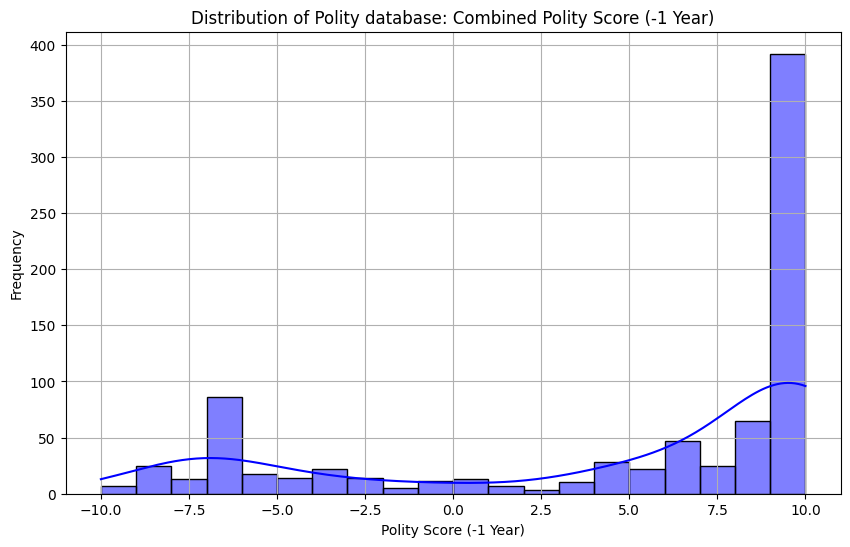

In [322]:
# Make a copy of the final_df before analysis to preserve the original
analysis_df = final_df.copy()

# 1. Calculate the average score at -1 year
mean_score = analysis_df['Polity database: Combined Polity Score_-1'].mean()
print("Average Polity database: Combined Polity Score (-1 year):", mean_score)

# 2. Show the distribution
scores = analysis_df['Polity database: Combined Polity Score_-1'].dropna()

# Make a copy of scores if you plan to do further analysis on it
scores_for_plot = scores.copy()

plt.figure(figsize=(10, 6))
sns.histplot(scores_for_plot, kde=True, bins=20, color='blue')
plt.title("Distribution of Polity database: Combined Polity Score (-1 Year)")
plt.xlabel("Polity Score (-1 Year)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

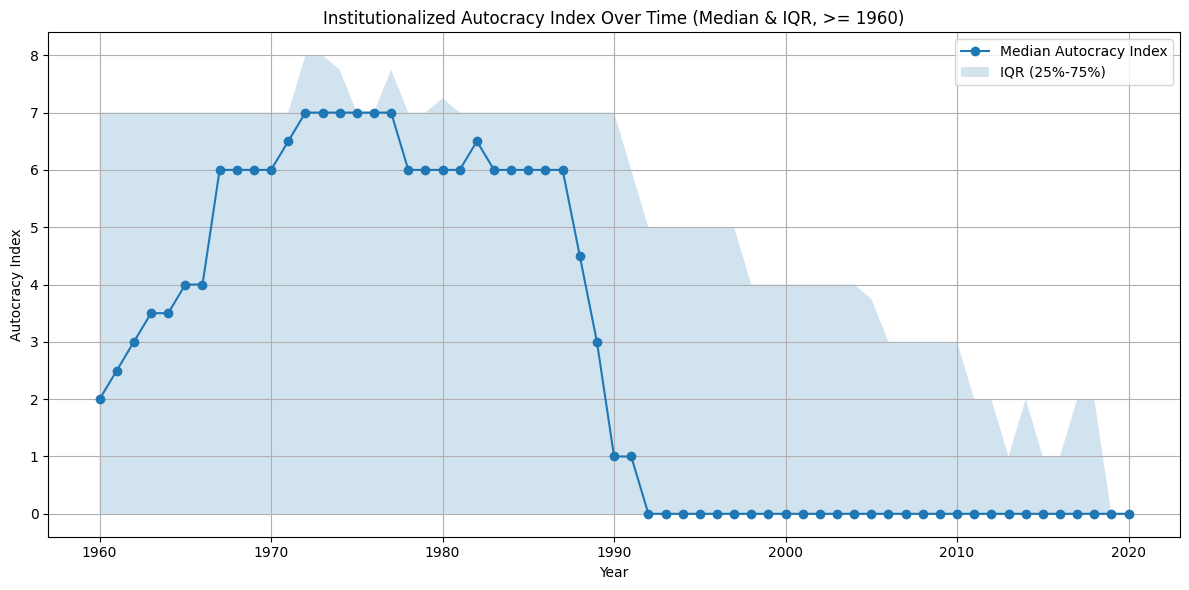

In [323]:
# Make a copy of the original DataFrame
analysis_df = plty_df.copy()

# Filter for the Institutionalized Autocracy Index
autoc_df = analysis_df[analysis_df['Indicator'] == 'Polity database: Institutionalized Autocracy Index']

# Identify year columns
year_columns = [col for col in autoc_df.columns if col.isdigit()]

# Melt into long format
melted_autoc = autoc_df.melt(
    id_vars=['Economy Name', 'Indicator'], 
    value_vars=year_columns, 
    var_name='Year', 
    value_name='AutocracyIndex'
)

# Convert columns to numeric
melted_autoc['Year'] = pd.to_numeric(melted_autoc['Year'], errors='coerce')
melted_autoc['AutocracyIndex'] = pd.to_numeric(melted_autoc['AutocracyIndex'], errors='coerce')
melted_autoc = melted_autoc.dropna(subset=['AutocracyIndex', 'Year'])

# Exclude data before 1970
melted_autoc = melted_autoc[melted_autoc['Year'] >= 1960]

# Group by year and calculate median and IQR
yearly_stats = melted_autoc.groupby('Year')['AutocracyIndex'].agg(median='median')
yearly_stats['Q1'] = melted_autoc.groupby('Year')['AutocracyIndex'].quantile(0.25)
yearly_stats['Q3'] = melted_autoc.groupby('Year')['AutocracyIndex'].quantile(0.75)

# Plot the median line and shading for IQR
plt.figure(figsize=(12, 6))
plt.plot(yearly_stats.index, yearly_stats['median'], marker='o', label='Median Autocracy Index')
plt.fill_between(yearly_stats.index, yearly_stats['Q1'], yearly_stats['Q3'], alpha=0.2, label='IQR (25%-75%)')

plt.title('Institutionalized Autocracy Index Over Time (Median & IQR, >= 1960)')
plt.xlabel('Year')
plt.ylabel('Autocracy Index')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

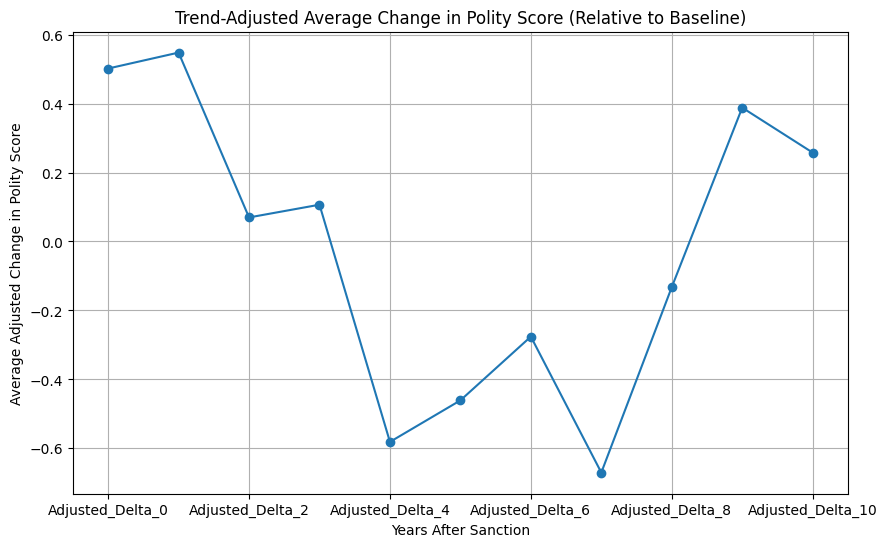

In [324]:
# Parameters
indicator_name = "Polity database: Institutionalized Autocracy Index"
years_post_sanction = range(0, 11)  # From 0 to +10 years after the sanction
baseline_offset = -1

analysis_df = final_df.copy()

# Baseline column
baseline_col = f"{indicator_name}_{baseline_offset}"

# Drop rows without a baseline score
analysis_df = analysis_df.dropna(subset=[baseline_col])

# Ensure we have all needed columns for the offsets we want
required_cols = [baseline_col] + [f"{indicator_name}_{y}" for y in years_post_sanction]
analysis_df = analysis_df.dropna(subset=[c for c in required_cols if c in analysis_df.columns])

#------------------------------------------------------------
# Step 3: Adjust by Global Yearly Means
#------------------------------------------------------------
# For each row (event) and each offset y:
# Actual baseline year = startyear - 1
# Actual offset year = startyear + y
#
# Adjusted score for a given year = (event_score - global_mean_for_that_year)
# Adjusted delta = [ (adjusted_score(startyear+y)) - (adjusted_score(startyear-1)) ]

for y in years_post_sanction:
    current_col = f"{indicator_name}_{y}"
    adjusted_col = f"Adjusted_Delta_{y}"
    
    baseline_years = analysis_df['startyear'] + baseline_offset
    current_years = analysis_df['startyear'] + y
    
    # Get global means aligned with each row
    global_baseline_means = global_pivot[indicator_name].reindex(baseline_years.values).values
    global_current_means = global_pivot[indicator_name].reindex(current_years.values).values
    
    # Raw scores from the event
    baseline_scores = analysis_df[baseline_col].values
    current_scores = analysis_df[current_col].values
    
    # Adjusted delta:
    # = [(current_score - global_current_mean) - (baseline_score - global_baseline_mean)]
    adjusted_delta = (current_scores - global_current_means) - (baseline_scores - global_baseline_means)
    
    analysis_df[adjusted_col] = adjusted_delta

# Identify adjusted delta columns
adjusted_delta_cols = [f"Adjusted_Delta_{y}" for y in years_post_sanction if f"Adjusted_Delta_{y}" in analysis_df.columns]

# Compute the average adjusted deltas
avg_adjusted_deltas = analysis_df[adjusted_delta_cols].mean()

# Plot the trend-controlled changes
plt.figure(figsize=(10,6))
avg_adjusted_deltas.plot(marker='o')
plt.title("Trend-Adjusted Average Change in Polity Score (Relative to Baseline)")
plt.xlabel("Years After Sanction")
plt.ylabel("Average Adjusted Change in Polity Score")
plt.grid(True)
plt.show()

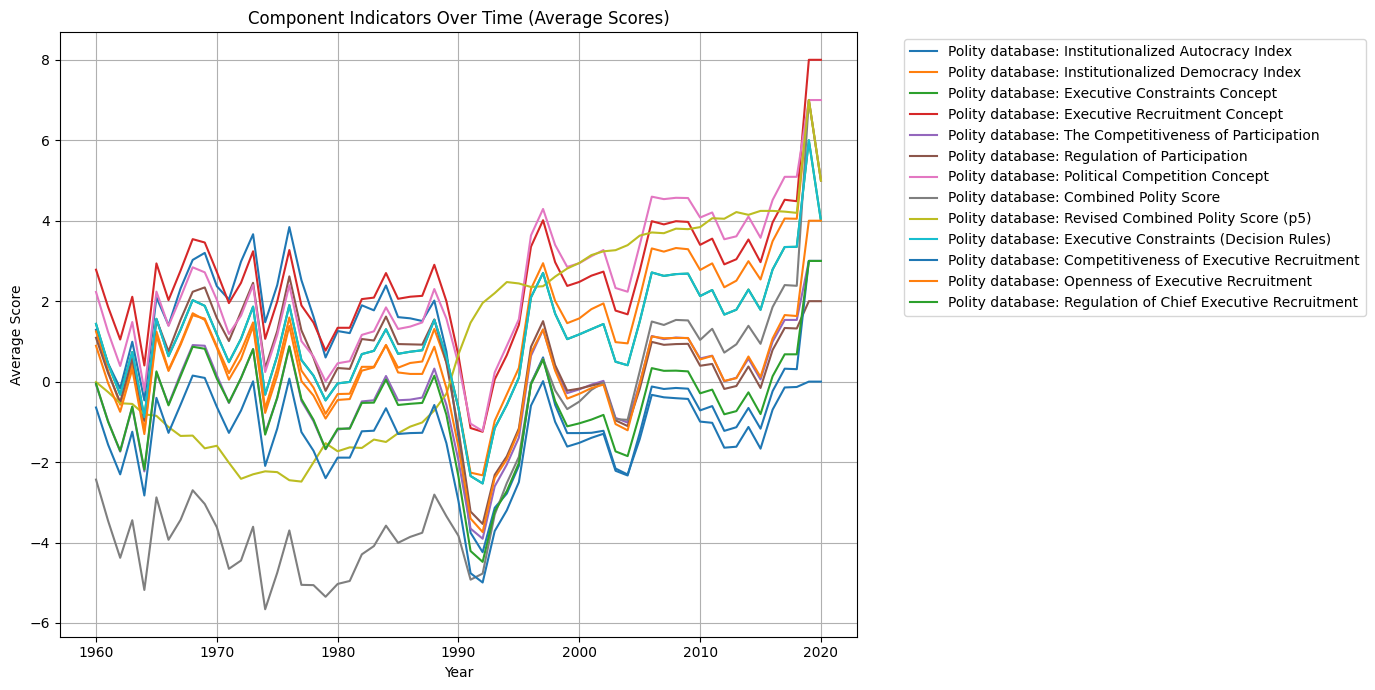

In [325]:
components_of_interest = ['Polity database: Institutionalized Autocracy Index',
       'Polity database: Institutionalized Democracy Index',
       'Polity database: Executive Constraints Concept',
       'Polity database: Executive Recruitment Concept',
       'Polity database: The Competitiveness of Participation',
       'Polity database: Regulation of Participation',
       'Polity database: Political Competition Concept',
       'Polity database: Combined Polity Score',
       'Polity database: Revised Combined Polity Score (p5)',
       'Polity database: Executive Constraints (Decision Rules)',
       'Polity database: Competitiveness of Executive Recruitment',
       'Polity database: Openness of Executive Recruitment',
       'Polity database: Regulation of Chief Executive Recruitment']
comp_df = plty_df[plty_df['Indicator'].isin(components_of_interest)].copy()
# Identify year columns (assuming same format as before)
year_columns = [col for col in comp_df.columns if col.isdigit()]

# Melt into long format: Economy Name, Indicator, Year, Value
melted_comp = comp_df.melt(
    id_vars=['Economy Name', 'Indicator'],
    value_vars=year_columns,
    var_name='Year',
    value_name='Score'
)

# Convert types
melted_comp['Year'] = pd.to_numeric(melted_comp['Year'], errors='coerce')
melted_comp['Score'] = pd.to_numeric(melted_comp['Score'], errors='coerce')

melted_comp = melted_comp.dropna(subset=['Score', 'Year'])

# Optional: Filter for time period (e.g., >= 1970)
melted_comp = melted_comp[melted_comp['Year'] >= 1960]

# Compute annual averages for each component
annual_components = melted_comp.groupby(['Indicator','Year'])['Score'].mean().reset_index()

# Pivot so each component is a column; rows = Year
annual_pivot = annual_components.pivot(index='Year', columns='Indicator', values='Score')

# Now 'annual_pivot' has a row per year and a column per each component indicator
# You can plot trends of components over time:
plt.figure(figsize=(14,7))
for indicator in components_of_interest:
    if indicator in annual_pivot.columns:
        plt.plot(annual_pivot.index, annual_pivot[indicator], label=indicator)

plt.title("Component Indicators Over Time (Average Scores)")
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

Trend-Adjusted Average 10-Year Impact on Polity Components:
    Polity database: Institutionalized Autocracy Index  \
0                                           -0.916023    
1                                           -2.607814    
2                                           -4.035416    
3                                           -3.222296    
4                                           -4.556021    
5                                           -3.589903    
6                                           -3.727796    
7                                           -5.524590    
8                                           -3.823994    
9                                           -3.904198    
10                                          -5.377050    

    Polity database: Institutionalized Democracy Index  \
0                                           -0.614076    
1                                           -1.892615    
2                                           -2.994262    
3          

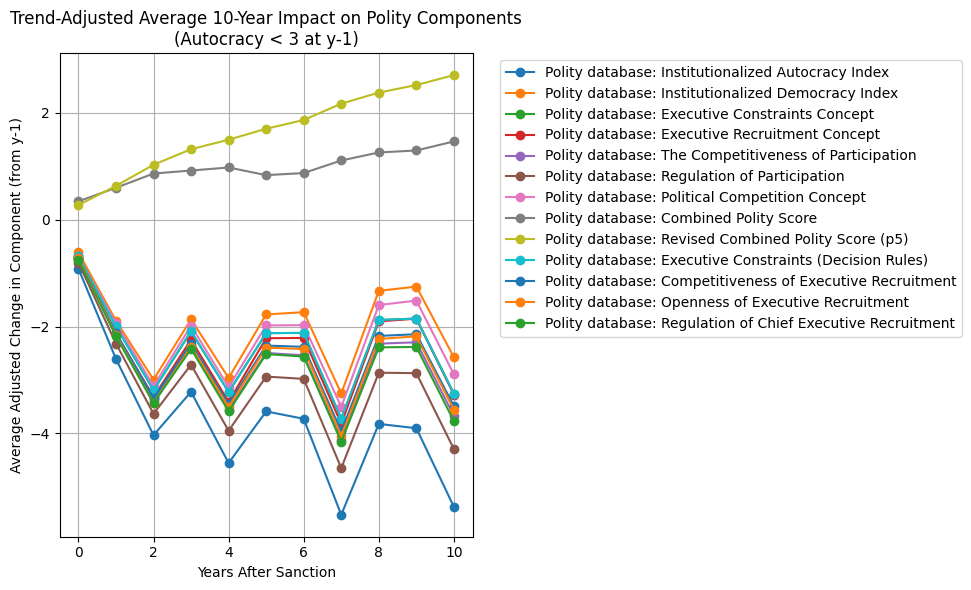

In [326]:
autocracy_threshold = 3
years_post_sanction = range(0, 11)

analysis_df = final_df.copy()

# Filter for autocracy threshold at y-1
analysis_df = analysis_df.dropna(subset=["Polity database: Institutionalized Autocracy Index_-1"])
analysis_df = analysis_df[analysis_df["Polity database: Institutionalized Autocracy Index_-1"] > autocracy_threshold]

# We'll store adjusted averages
avg_adjusted_deltas = {}

for comp in components_of_interest:
    required_cols = [f"{comp}_{y}" for y in [-1] + list(years_post_sanction)]
    comp_df = analysis_df.dropna(subset=required_cols).copy()
    
    # Compute raw deltas from baseline (y-1)
    for y in years_post_sanction:
        baseline_col = f"{comp}_-1"
        current_col = f"{comp}_{y}"
        delta_col = f"Delta_{comp}_{y}"
        comp_df[delta_col] = comp_df[current_col] - comp_df[baseline_col]
    
    # Now adjust by global trend:
    # For each event (row), and each y:
    # Find actual year = startyear + y and subtract the global mean delta from that year.
    # Wait, we need to handle global trend properly:
    # The baseline is at startyear-1. For offset y, the actual year is startyear+y.
    # We'll adjust both the baseline and current year's scores by their global means,
    # then recompute the delta. This ensures a proper alignment with global trends.
    
    for y in years_post_sanction:
        baseline_year = comp_df['startyear'] - 1
        current_year = comp_df['startyear'] + y
        
        # Get global baseline mean score for baseline_year and global current mean score for current_year
        # Use .reindex to handle missing years gracefully
        global_baseline_means = global_pivot[comp].reindex(baseline_year.values)
        global_current_means = global_pivot[comp].reindex(current_year.values)
        
        # Adjusted delta = ( (current_score - global_current_mean) - (baseline_score - global_baseline_mean) )
        # We already have current_score and baseline_score in comp_df, let's do it directly:
        baseline_col = f"{comp}_-1"
        current_col = f"{comp}_{y}"
        adjusted_col = f"Adjusted_Delta_{comp}_{y}"
        
        # Convert the global means into arrays aligned with comp_df rows
        comp_df['global_baseline_mean'] = global_baseline_means.values
        comp_df['global_current_mean'] = global_current_means.values
        
        comp_df[adjusted_col] = ( (comp_df[current_col] - comp_df['global_current_mean']) 
                                - (comp_df[baseline_col] - comp_df['global_baseline_mean']) )
    
    # Compute average adjusted deltas across all events
    avg_adjusted_deltas[comp] = [comp_df[f"Adjusted_Delta_{comp}_{y}"].mean() for y in years_post_sanction]

# Create a DataFrame for the adjusted deltas
adjusted_delta_df = pd.DataFrame(avg_adjusted_deltas, index=years_post_sanction)

print("Trend-Adjusted Average 10-Year Impact on Polity Components:")
print(adjusted_delta_df)

# Plot
plt.figure(figsize=(10,6))
for comp in components_of_interest:
    plt.plot(adjusted_delta_df.index, adjusted_delta_df[comp], marker='o', label=comp)

plt.title(f"Trend-Adjusted Average 10-Year Impact on Polity Components\n(Autocracy < {autocracy_threshold} at y-1)")
plt.xlabel("Years After Sanction")
plt.ylabel("Average Adjusted Change in Component (from y-1)")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Key here is that overall increases while auto and demo decrease

### Linear Regression Factor From Polity

In [327]:
# Parameters
autocracy_threshold = 1
years_post_sanction = range(0, 11)
baseline_offset = -1

# Choose an outcome variable for the +10 year impact
# Let's pick Institutionalized Autocracy Index as the outcome
dep_indicator = 'Polity database: Institutionalized Autocracy Index'
dep_offset = 10

analysis_df = final_df.copy()

# Baseline columns for all indicators
baseline_cols = [f"{ind}_{baseline_offset}" for ind in components_of_interest]

# We must have the dependent variable columns: baseline and +10 for the chosen dep_indicator
dep_baseline_col = f"{dep_indicator}_{baseline_offset}"
dep_current_col = f"{dep_indicator}_{dep_offset}"

required_cols = baseline_cols + [dep_current_col]

# Filter for autocracy threshold at y-1 using the dep_indicator baseline as a reference
analysis_df = analysis_df.dropna(subset=[dep_baseline_col])
analysis_df = analysis_df[analysis_df[dep_baseline_col] > autocracy_threshold]

# Ensure all required columns exist
for c in required_cols:
    if c not in analysis_df.columns:
        raise ValueError(f"Missing required column: {c}")
        
# Drop rows missing any required columns
analysis_df = analysis_df.dropna(subset=required_cols)

comp_df = analysis_df.copy()

# Compute adjusted deltas for the dependent variable using global trends
# Adjusted delta formula:
# Adjusted_Delta = ( (current_score - global_current_mean) - (baseline_score - global_baseline_mean) )

baseline_years = comp_df['startyear'] + baseline_offset
current_years = comp_df['startyear'] + dep_offset

# Get global baseline and current means for the dependent indicator
global_baseline_means = global_pivot[dep_indicator].reindex(baseline_years.values)
global_current_means = global_pivot[dep_indicator].reindex(current_years.values)

comp_df['global_baseline_mean'] = global_baseline_means.values
comp_df['global_current_mean'] = global_current_means.values

comp_df['Adjusted_Delta_dep'] = ((comp_df[dep_current_col] - comp_df['global_current_mean']) 
                               - (comp_df[dep_baseline_col] - comp_df['global_baseline_mean']))

# Now we have an adjusted 10-year delta for the dependent variable: 'Adjusted_Delta_dep'

# Prepare the predictor variables:
# All indicators at baseline (y-1) will be predictors
X = comp_df[baseline_cols].copy()
y = comp_df['Adjusted_Delta_dep']


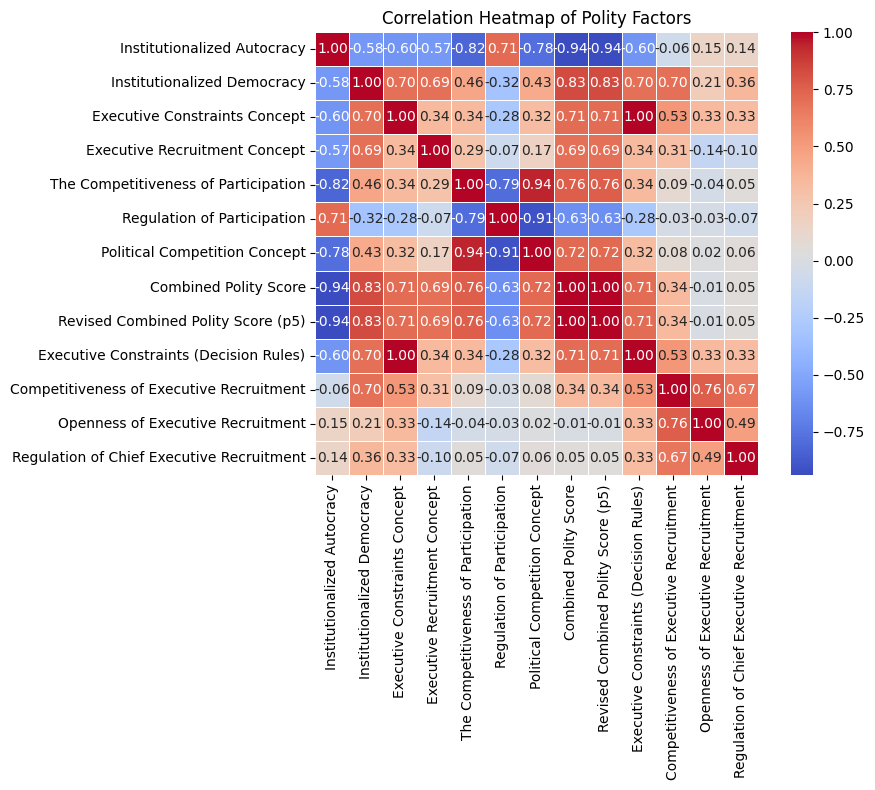

In [328]:
# Define the pattern to extract text after ": " and before " Index" or "_"
pattern = r":\s(.+?)(?:\sIndex|_|$)"

def extract_substring(col_name):
    match = re.search(pattern, col_name)
    if match:
        return match.group(1)
    else:
        return col_name  # If no match, keep original name

# Suppose X is your DataFrame of predictors
# Rename columns according to the pattern
X_renamed = X.copy()
X_renamed.columns = [extract_substring(col) for col in X_renamed.columns]

# Compute the correlation matrix
corr = X_renamed.corr()

# Create a matplotlib figure and axis
plt.figure(figsize=(10, 8))

# Create a heatmap with the renamed columns
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", square=True, linewidths=.5)

plt.title("Correlation Heatmap of Polity Factors")
plt.tight_layout()
plt.show()

In [329]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                                              feature         VIF
0   Polity database: Institutionalized Autocracy I...         inf
1   Polity database: Institutionalized Democracy I...         inf
2   Polity database: Executive Constraints Concept_-1         inf
3   Polity database: Executive Recruitment Concept_-1   51.885022
4   Polity database: The Competitiveness of Partic...  111.509031
5     Polity database: Regulation of Participation_-1  630.761952
6   Polity database: Political Competition Concept_-1   47.288033
7           Polity database: Combined Polity Score_-1         inf
8   Polity database: Revised Combined Polity Score...         inf
9   Polity database: Executive Constraints (Decisi...         inf
10  Polity database: Competitiveness of Executive ...   73.093435
11  Polity database: Openness of Executive Recruit...   43.259677
12  Polity database: Regulation of Chief Executive...   82.572679


c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [330]:
X = X.loc[:, ~X.columns.str.contains(r"Executive Constraints \(Decision\)|Executive Constraints Concept", case=False)]

X = X.loc[:, ~X.columns.str.contains("Institutionalized Autocracy Index")]

# Drop Regulation of Participation_-1
X = X.loc[:, ~X.columns.str.contains("ombined Polity Score_-1")]

X = X.loc[:, ~X.columns.str.contains("Regulation of Participation_-1")]

# X = X.loc[:, ~X.columns.str.contains("Institutionalized Democracy Index_-1")]
# X = X.loc[:, ~X.columns.str.contains("Competitiveness of Executive")]
# X = X.loc[:, ~X.columns.str.contains("Regulation of Chief Executive")]

# Drop either The Competitiveness of Participation or Political Competition Concept
# If you choose to keep Political Competition Concept, drop The Competitiveness of Participation:
X = X.loc[:, ~X.columns.str.contains("The Competitiveness of Participation")]

In [331]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                                             feature        VIF
0  Polity database: Institutionalized Democracy I...  18.125967
1  Polity database: Executive Recruitment Concept_-1  10.437532
2  Polity database: Political Competition Concept_-1   7.108488
3  Polity database: Revised Combined Polity Score...  24.067184
4  Polity database: Executive Constraints (Decisi...  14.055160
5  Polity database: Competitiveness of Executive ...  65.711841
6  Polity database: Openness of Executive Recruit...  34.016634
7  Polity database: Regulation of Chief Executive...  53.835650


In [332]:
# --------------------------------------------
# Better Time-Series Standardization
# --------------------------------------------
# One possible improvement for time-series standardization:
# Standardize each year's data relative to that year's distribution.
# This means for each feature, subtract the mean and divide by the std dev
# computed only from data in the same startyear.
# This step controls for global shifts over time in the distribution of features.

baseline_cols = [col for col in baseline_cols if col in X.columns]

def time_series_standardize(df, features, group_col='startyear'):
    df = df.copy()
    # Group by year and standardize each feature within that year
    for f in features:
        df[f] = df.groupby(group_col)[f].transform(
            lambda x: (x - x.mean()) / x.std(ddof=0) if x.std(ddof=0) != 0 else x - x.mean()
        )
    return df

# Standardize features year-by-year
X_time_std = time_series_standardize(pd.concat([comp_df['startyear'], X], axis=1), features=baseline_cols, group_col='startyear')
X_time_std = X_time_std[baseline_cols]

# Similarly, you could standardize y year-by-year, although this may not always be desired
# If you want to remove yearly global shifts in the dependent variable as well:
dep_var = 'Adjusted_Delta_dep'  # Define dep_var to match your dependent variable column name

y_time_std = time_series_standardize(
    pd.concat([comp_df['startyear'], y], axis=1),
    features=[dep_var],
    group_col='startyear'
)[dep_var]
# If you prefer global standardization (not year-by-year), use StandardScaler:
# scaler_X = StandardScaler()
# X_std = scaler_X.fit_transform(X)
# scaler_y = StandardScaler()
# y_std = scaler_y.fit_transform(y.values.reshape(-1,1)).ravel()

# For this example, we'll proceed with the time-series standardized values
X_train = X_time_std
y_train = y_time_std

Reduction in multicolin reduced R^2 by 0.02 from 0.18

Coefficients (time-series standardized):
Polity database: Institutionalized Democracy Index_-1            0.050450
Polity database: Executive Recruitment Concept_-1               -0.149496
Polity database: Political Competition Concept_-1               -0.122041
Polity database: Revised Combined Polity Score (p5)_-1          -0.117252
Polity database: Executive Constraints (Decision Rules)_-1       0.337945
Polity database: Competitiveness of Executive Recruitment_-1     0.314207
Polity database: Openness of Executive Recruitment_-1           -0.340949
Polity database: Regulation of Chief Executive Recruitment_-1   -0.123760
dtype: float64
Intercept: 0.002157987470525206
R-squared: 0.12085051876078312


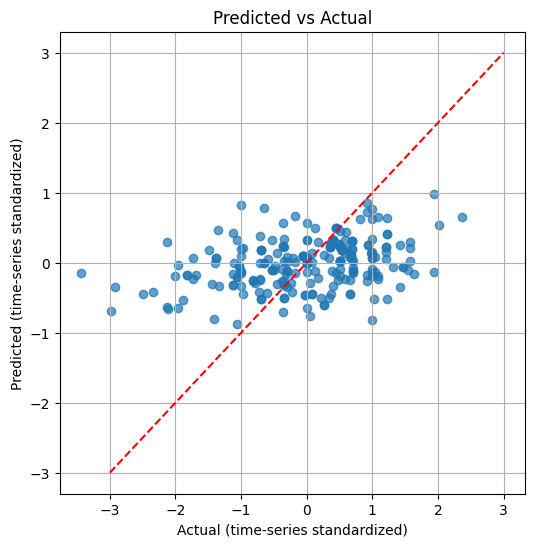

In [333]:
# --------------------------------------------
# Fit model using scikit-learn LinearRegression
# --------------------------------------------
model = LinearRegression()
model.fit(X_train, y_train)

# Check coefficients
coefs = pd.Series(model.coef_, index=baseline_cols)
print("Coefficients (time-series standardized):")
print(coefs)
print("Intercept:", model.intercept_)

# If you want to evaluate predictions:
y_pred = model.predict(X_train)

# Evaluate model performance (e.g., R^2)
r2 = model.score(X_train, y_train)
print("R-squared:", r2)

# Plot predicted vs actual
plt.figure(figsize=(6,6))
plt.scatter(y_train, y_pred, alpha=0.7)
plt.plot([-3,3],[-3,3], 'r--')  # if standardized, y should roughly be in a similar scale
plt.xlabel("Actual (time-series standardized)")
plt.ylabel("Predicted (time-series standardized)")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

# Interpretation:
# - This code applies a year-by-year standardization that accounts for time-series structure.
# - The LinearRegression model fits the standardized predictors to the standardized dependent variable.
# - The coefficients and R² help understand how baseline conditions relate to the adjusted outcome after controlling for year-specific distributions.

In [334]:
# Add a constant term for OLS
X_train_const = sm.add_constant(X_train)

# Fit OLS model
ols_model = sm.OLS(y_train, X_train_const)
ols_results = ols_model.fit()

# Print summary to see coefficients, p-values, t-stats, and significance levels
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:     Adjusted_Delta_dep   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     4.004
Date:                Wed, 11 Dec 2024   Prob (F-statistic):           0.000180
Time:                        12:16:02   Log-Likelihood:                -322.17
No. Observations:                 242   AIC:                             662.3
Df Residuals:                     233   BIC:                             693.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [335]:
# 2 YRS 3 AUTO

#                              OLS Regression Results                            
# ==============================================================================
# Dep. Variable:     Adjusted_Delta_dep   R-squared:                       0.124
# Model:                            OLS   Adj. R-squared:                  0.087
# Method:                 Least Squares   F-statistic:                     3.393
# Date:                Wed, 11 Dec 2024   Prob (F-statistic):            0.00114
# Time:                        08:08:07   Log-Likelihood:                -253.89
# No. Observations:                 201   AIC:                             525.8
# Df Residuals:                     192   BIC:                             555.5
# Df Model:                           8                                         
# Covariance Type:            nonrobust                                         
# =================================================================================================================================
#                                                                     coef    std err          t      P>|t|      [0.025      0.975]
# ---------------------------------------------------------------------------------------------------------------------------------
# const                                                            -0.0005      0.062     -0.008      0.994      -0.122       0.121
# Polity database: Institutionalized Democracy Index_-1             0.2429      0.155      1.566      0.119      -0.063       0.549
# Polity database: Executive Recruitment Concept_-1                -0.0814      0.129     -0.631      0.529      -0.336       0.173
# Polity database: Political Competition Concept_-1                -0.3230      0.125     -2.583      0.011      -0.570      -0.076
# Polity database: Revised Combined Polity Score (p5)_-1            0.0611      0.200      0.306      0.760      -0.333       0.455
# Polity database: Executive Constraints (Decision Rules)_-1        0.1240      0.121      1.023      0.308      -0.115       0.363
# Polity database: Competitiveness of Executive Recruitment_-1     -0.1195      0.202     -0.593      0.554      -0.517       0.278
# Polity database: Openness of Executive Recruitment_-1             0.2094      0.146      1.430      0.154      -0.079       0.498
# Polity database: Regulation of Chief Executive Recruitment_-1    -0.1493      0.113     -1.320      0.189      -0.373       0.074
# ==============================================================================
# Omnibus:                       40.760   Durbin-Watson:                   2.411
# ...
# ==============================================================================

# 10 YRS 4 AUTO

#                            OLS Regression Results                            
# ==============================================================================
# Dep. Variable:     Adjusted_Delta_dep   R-squared:                       0.168
# Model:                            OLS   Adj. R-squared:                  0.126
# Method:                 Least Squares   F-statistic:                     4.003
# Date:                Wed, 11 Dec 2024   Prob (F-statistic):           0.000238
# Time:                        08:09:14   Log-Likelihood:                -216.20
# No. Observations:                 168   AIC:                             450.4
# Df Residuals:                     159   BIC:                             478.5
# Df Model:                           8                                         
# Covariance Type:            nonrobust                                         
# =================================================================================================================================
#                                                                     coef    std err          t      P>|t|      [0.025      0.975]
# ---------------------------------------------------------------------------------------------------------------------------------
# const                                                             0.0031      0.069      0.045      0.964      -0.134       0.140
# Polity database: Institutionalized Democracy Index_-1            -0.2448      0.353     -0.694      0.489      -0.941       0.452
# Polity database: Executive Recruitment Concept_-1                -0.2024      0.197     -1.029      0.305      -0.591       0.186
# Polity database: Political Competition Concept_-1                -0.5550      0.138     -4.031      0.000      -0.827      -0.283
# Polity database: Revised Combined Polity Score (p5)_-1            0.4295      0.238      1.808      0.072      -0.040       0.899
# Polity database: Executive Constraints (Decision Rules)_-1       -0.0669      0.171     -0.391      0.696      -0.405       0.271
# Polity database: Competitiveness of Executive Recruitment_-1      0.2273      0.322      0.707      0.481      -0.408       0.863
# Polity database: Openness of Executive Recruitment_-1            -0.0561      0.234     -0.240      0.811      -0.518       0.406
# Polity database: Regulation of Chief Executive Recruitment_-1     0.0470      0.180      0.262      0.794      -0.308       0.402
# ==============================================================================
# Omnibus:                        8.459   Durbin-Watson:                   2.491
# ...
# ==============================================================================

# 10 YRS REVISED LT 2

#                             OLS Regression Results                            
# ==============================================================================
# Dep. Variable:     Adjusted_Delta_dep   R-squared:                       0.137
# Model:                            OLS   Adj. R-squared:                  0.117
# Method:                 Least Squares   F-statistic:                     6.930
# Date:                Wed, 11 Dec 2024   Prob (F-statistic):           5.01e-06
# Time:                        08:15:01   Log-Likelihood:                -294.62
# No. Observations:                 224   AIC:                             601.2
# Df Residuals:                     218   BIC:                             621.7
# Df Model:                           5                                         
# Covariance Type:            nonrobust                                         
# ==============================================================================================================================
#                                                                  coef    std err          t      P>|t|      [0.025      0.975]
# ------------------------------------------------------------------------------------------------------------------------------
# const                                                         -0.0045      0.061     -0.073      0.942      -0.125       0.116
# Polity database: Executive Recruitment Concept_-1              0.2326      0.107      2.170      0.031       0.021       0.444
# Polity database: Political Competition Concept_-1              0.4874      0.149      3.267      0.001       0.193       0.781
# Polity database: Revised Combined Polity Score (p5)_-1        -0.2530      0.205     -1.236      0.218      -0.656       0.150
# Polity database: Executive Constraints (Decision Rules)_-1    -0.1146      0.107     -1.067      0.287      -0.326       0.097
# Polity database: Openness of Executive Recruitment_-1          0.0568      0.076      0.746      0.457      -0.093       0.207
# ==============================================================================
# Omnibus:                        6.133   Durbin-Watson:                   2.287
# Prob(Omnibus):                  0.047   Jarque-Bera (JB):                6.283
# Skew:                           0.390   Prob(JB):                       0.0432
# Kurtosis:                       2.747   Cond. No.                         6.41
# ==============================================================================


# WHEN ACTUALLTY IMPOSED

# Coefficients (time-series standardized):
# Polity database: Institutionalized Democracy Index_-1           -0.144586
# Polity database: Executive Recruitment Concept_-1               -0.249653
# Polity database: Political Competition Concept_-1               -0.417471
# Polity database: Revised Combined Polity Score (p5)_-1           0.247176
# Polity database: Executive Constraints (Decision Rules)_-1       0.358496
# Polity database: Competitiveness of Executive Recruitment_-1     0.245649
# Polity database: Openness of Executive Recruitment_-1           -0.341008
# Polity database: Regulation of Chief Executive Recruitment_-1    0.010772
# dtype: float64
# Intercept: 0.001077060426817932
# R-squared: 0.21982417811514277

### Non-Linear Model

Training R²: 0.7993596961410889
Test R²: -0.09783486026137811
Feature Importances:
                                             feature  importance
4  Polity database: Executive Constraints (Decisi...    0.219631
2  Polity database: Political Competition Concept_-1    0.163398
3  Polity database: Revised Combined Polity Score...    0.125761
6  Polity database: Openness of Executive Recruit...    0.125039
0  Polity database: Institutionalized Democracy I...    0.107428
7  Polity database: Regulation of Chief Executive...    0.103111
5  Polity database: Competitiveness of Executive ...    0.085278
1  Polity database: Executive Recruitment Concept_-1    0.070353

Permutation Importances (on test set):
                                             feature  importance_mean  \
4  Polity database: Executive Constraints (Decisi...         0.081437   
0  Polity database: Institutionalized Democracy I...         0.048970   
7  Polity database: Regulation of Chief Executive...         0.019725   


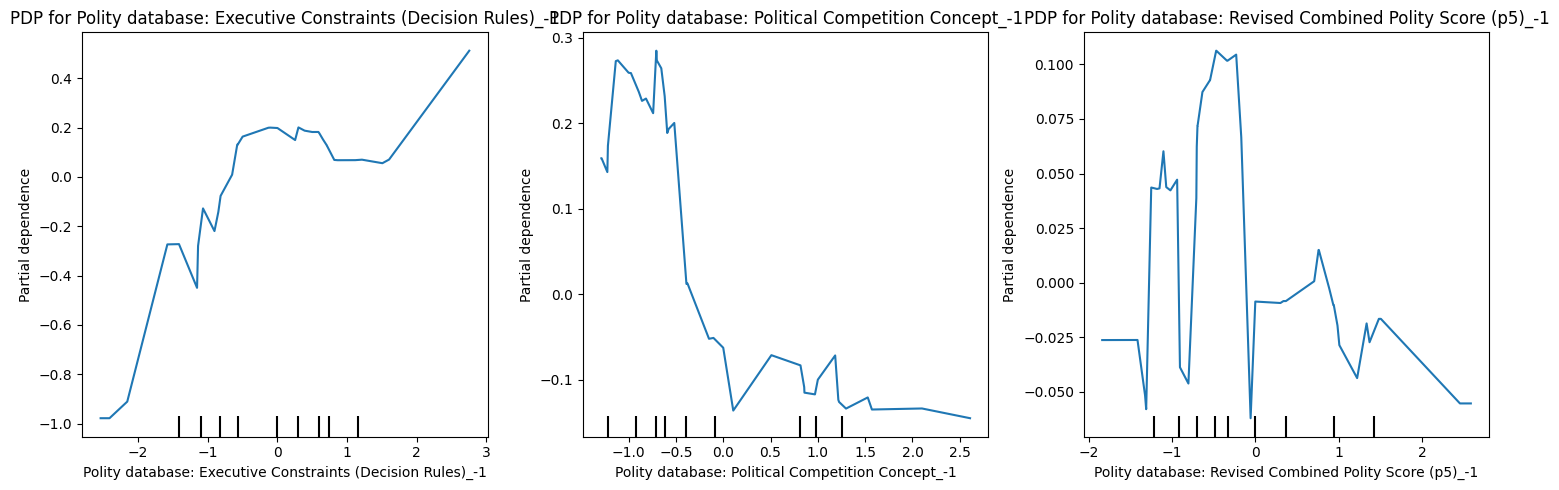

In [336]:
# Split data into train and test for honest evaluation
X_train, X_test, y_train, y_test = train_test_split(X_time_std, y_time_std, test_size=0.25, random_state=1)

# Fit a tree-based model: Random Forest
rf = RandomForestRegressor(n_estimators=30, random_state=1)
rf.fit(X_train, y_train)

# Evaluate performance on test set
r2_train = rf.score(X_train, y_train)
r2_test = rf.score(X_test, y_test)
print("Training R²:", r2_train)
print("Test R²:", r2_test)

# Feature importance
# RandomForest provides a straightforward feature_importances_ attribute
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': baseline_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

# Optional: Permutation Importance for more reliable feature importance assessment
perm_import = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)
perm_import_df = pd.DataFrame({
    'feature': baseline_cols,
    'importance_mean': perm_import.importances_mean,
    'importance_std': perm_import.importances_std
}).sort_values('importance_mean', ascending=False)

print("\nPermutation Importances (on test set):")
print(perm_import_df)

# Partial Dependence Plots
# We'll pick a few top features based on importance for partial dependence
top_features = feature_importance_df['feature'].head(3).to_list()

fig, axs = plt.subplots(nrows=1, ncols=len(top_features), figsize=(15, 5))
for i, feat in enumerate(top_features):
    PartialDependenceDisplay.from_estimator(rf, X_test, features=[baseline_cols.index(feat)],
                                            feature_names=baseline_cols,
                                            ax=axs[i])
    axs[i].set_title(f'PDP for {feat}')
plt.tight_layout()
plt.show()

In [337]:
from sklearn.linear_model import Ridge

In [338]:
# Using Lasso as an example; you can also try Ridge or ElasticNet
model = Ridge(alpha=1, random_state=42)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_time_std, y_time_std, test_size=0.25, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Predict on train and test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R² scores
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Training R²:", r2_train)
print("Test R²:", r2_test)

# Inspect coefficients
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_
}).sort_values('coefficient', ascending=False)

print("Coefficients:")
print(coef_df)

Training R²: 0.11387962510547123
Test R²: 0.11000069877118468
Coefficients:
                                             feature  coefficient
4  Polity database: Executive Constraints (Decisi...     0.291355
5  Polity database: Competitiveness of Executive ...     0.231344
3  Polity database: Revised Combined Polity Score...     0.082754
0  Polity database: Institutionalized Democracy I...    -0.013479
7  Polity database: Regulation of Chief Executive...    -0.076106
1  Polity database: Executive Recruitment Concept_-1    -0.186750
2  Polity database: Political Competition Concept_-1    -0.191284
6  Polity database: Openness of Executive Recruit...    -0.292880


### Predicting Prob of Impose

Number of observations: 828
Number of features after encoding: 73
Training Accuracy: 0.789049919484702
Test Accuracy: 0.7584541062801933
ROC AUC on test set: 0.8079439252336449


c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


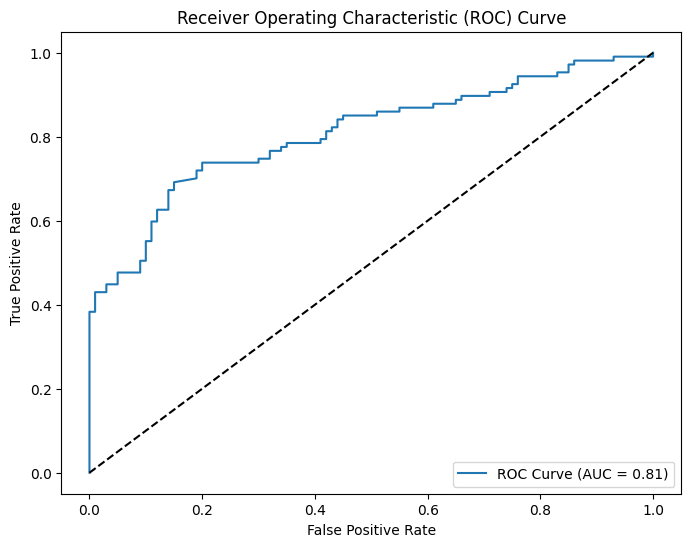

In [339]:
# Copy the final_df to a working dataframe
analysis_df = final_df.copy()

# Check and filter by settlementnaturesender
if 'settlementnaturesender' not in analysis_df.columns:
    raise ValueError("settlementnaturesender column not found.")

analysis_df = analysis_df.dropna(subset=['settlementnaturesender'])
analysis_df = analysis_df[analysis_df['imposition'] != 'Missing']

# Identify polity -1 year variables
polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]

# Listed TIES features (original + newly added)
ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'anticipatedtargetcosts',
    'anticipatedsendercosts',
    # Newly added features:
    'institution',  # Binary/ Missing -> treated as categorical
    'targetinstitution',  # Binary / Missing -> categorical
    'othersanctiontypethreatened', # categorical
    'dsanctions' # categorical (diplomatic sanctions)
]

all_features = polity_minus_one_vars + ties_features

# Check which features exist
final_features = []
for f in all_features:
    if f not in analysis_df.columns:
        print(f"Feature '{f}' not found, skipping it.")
    else:
        final_features.append(f)

if not final_features:
    raise ValueError("No features available after checking existence. Please revise variable selection.")

# Attempt to convert identified vars to numeric if possible
vars_to_process = final_features + ['settlementnaturesender']
for var in vars_to_process:
    analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

analysis_df = analysis_df[final_features + ['imposition']]

# Now treat ties_features as categorical
for var in ties_features:
    if var in analysis_df.columns:
        # Convert all entries to string to ensure consistency
        analysis_df[var] = analysis_df[var].astype(str)
        analysis_df[var] = analysis_df[var].astype('category')
        # Add a "Missing" category to handle NaN explicitly
        analysis_df[var] = analysis_df[var].cat.add_categories(["Missing"])
        analysis_df[var] = analysis_df[var].fillna("Missing")

# For polity_minus_one_vars, median-impute missing values
for var in polity_minus_one_vars:
    if var in analysis_df.columns:
        # Already numeric from above step
        col_median = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(col_median)

# Custom parsing function for any remaining non-numeric columns not in ties_features
def parse_numeric_string(val):
    if pd.isna(val):
        return val
    s = str(val)
    # Try to convert directly
    try:
        return float(s)
    except ValueError:
        # If it fails, maybe it's a space-separated pair of numbers
        parts = s.split()
        if len(parts) == 2:
            try:
                num1, num2 = float(parts[0]), float(parts[1])
                return (num1 + num2)/2.0
            except ValueError:
                return np.nan
        # If no known pattern, return NaN
        return np.nan

non_numeric_cols = analysis_df.select_dtypes(include=['object']).columns
for col in non_numeric_cols:
    if col not in ties_features:
        analysis_df[col] = analysis_df[col].apply(parse_numeric_string)
        # Try converting to numeric again
        analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')

# Remove columns that are entirely NaN
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        print(f"Feature '{var}' is all NaN, removing it.")
        final_features.remove(var)

if not final_features:
    raise ValueError("No usable features remain after removing all-NaN columns.")

# Define numerical and categorical features
numerical_features = [f for f in final_features if f in polity_minus_one_vars]
categorical_features = [f for f in ties_features if f in final_features]

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.90))  # Retain 90% of variance
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Define the full pipeline with a classifier
pipeline_prob_impose = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))  # Adjust parameters as needed
])

# Prepare target and features
X = analysis_df[numerical_features + categorical_features]
y = analysis_df['imposition']  # Change target variable here

# Ensure that 'imposition' is binary (0 and 1)
unique_impositions = y.unique()
if not set(unique_impositions).issubset({0, 1}):
    raise ValueError(f"Target variable 'imposition' must be binary (0 and 1). Found: {unique_impositions}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Fit the pipeline on training data
pipeline_prob_impose.fit(X_train, y_train)

# Evaluate the model
train_score = pipeline_prob_impose.score(X_train, y_train)
test_score = pipeline_prob_impose.score(X_test, y_test)

print("Number of observations:", len(analysis_df))
onehot_feature_names = pipeline_prob_impose.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
print("Number of features after encoding:", len(numerical_features) + onehot_feature_names.shape[0])
print("Training Accuracy:", train_score)
print("Test Accuracy:", test_score)

# Predict probabilities on the test set
y_pred_proba = pipeline_prob_impose.predict_proba(X_test)[:, 1]

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC on test set:", roc_auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Final Features After Preprocessing:
['PC1', 'PC2', 'issue1_10', 'issue1_11', 'issue1_12', 'issue1_13', 'issue1_14', 'issue1_15', 'issue1_2', 'issue1_3', 'issue1_4', 'issue1_5', 'issue1_6', 'issue1_7', 'issue1_8', 'issue1_9', 'threatid1_2.0', 'threatid1_3.0', 'threatid1_4.0', 'threatid1_5.0', 'threatid1_6.0', 'threatid1_7.0', 'threatid1_8.0', 'threatid1_nan', 'sanctiontypethreat_10.0', 'sanctiontypethreat_2.0', 'sanctiontypethreat_3.0', 'sanctiontypethreat_4.0', 'sanctiontypethreat_5.0', 'sanctiontypethreat_6.0', 'sanctiontypethreat_7.0', 'sanctiontypethreat_8.0', 'sanctiontypethreat_9.0', 'sanctiontypethreat_nan', 'bspecif_2.0', 'bspecif_nan', 'scommit_2.0', 'scommit_3.0', 'scommit_nan', 'threatenedtargetinterest_2.0', 'threatenedtargetinterest_3.0', 'threatenedtargetinterest_4.0', 'threatenedtargetinterest_5.0', 'threatenedtargetinterest_nan', 'carrots_2.0', 'carrots_3.0', 'carrots_5.0', 'carrots_nan', 'anticipatedtargetcosts_2.0', 'anticipatedtargetcosts_3.0', 'anticipatedtargetcost

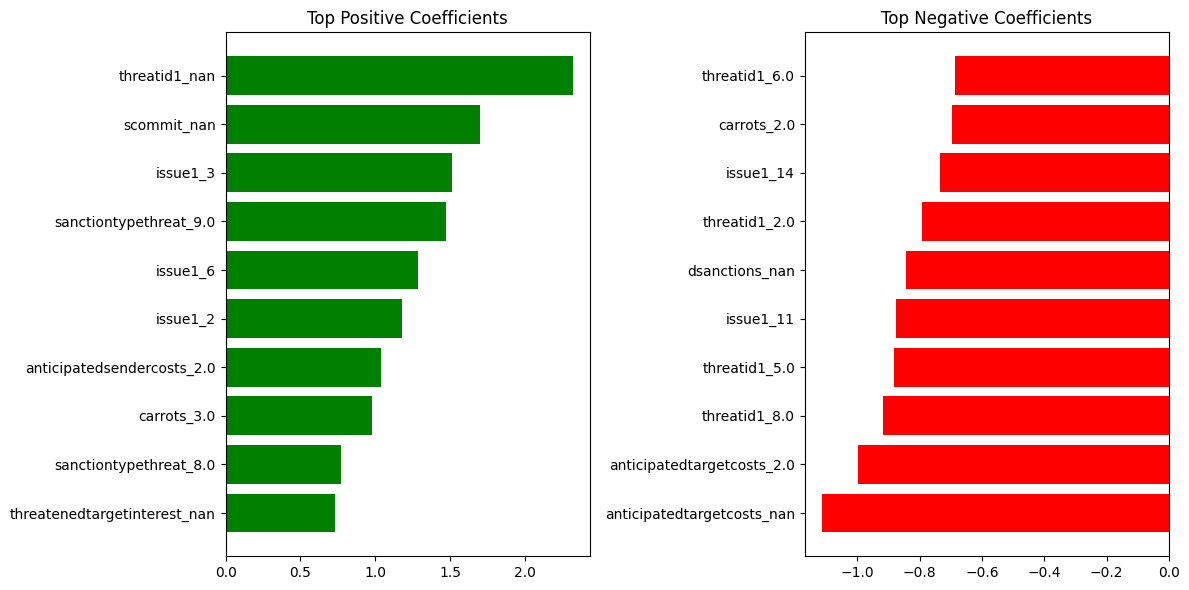


PCA Component Loadings:
     Polity database: Combined Polity Score_-1  \
PC1                                   0.012515   
PC2                                   0.665311   

     Polity database: Competitiveness of Executive Recruitment_-1  \
PC1                                           0.302056              
PC2                                          -0.028221              

     Polity database: Executive Constraints (Decision Rules)_-1  \
PC1                                           0.302134            
PC2                                           0.015687            

     Polity database: Executive Constraints Concept_-1  \
PC1                                           0.302134   
PC2                                           0.015687   

     Polity database: Executive Recruitment Concept_-1  \
PC1                                           0.301716   
PC2                                           0.010927   

     Polity database: Institutionalized Autocracy Index_-1  \
PC

In [340]:
# Extract pipeline steps
preprocessor = pipeline_prob_impose.named_steps['preprocessor']
clf = pipeline_prob_impose.named_steps['classifier']

# Identify the numeric and categorical pipelines
num_pipeline = preprocessor.transformers_[0][1]  # numeric pipeline
cat_encoder = preprocessor.transformers_[1][1]   # categorical encoder

pca = num_pipeline.named_steps['pca']
scaler = num_pipeline.named_steps['scaler']

# Number of principal components retained
num_pcs = pca.n_components_

# Create feature names for PCA components
pc_feature_names = [f'PC{i+1}' for i in range(num_pcs)]

# Extract the final categorical feature names after one-hot encoding
encoded_cat_features = cat_encoder.get_feature_names_out(categorical_features)

# Final feature names fed into the logistic regression
final_feature_names = pc_feature_names + list(encoded_cat_features)

print("\nFinal Features After Preprocessing:")
print(final_feature_names)

# Get logistic regression coefficients
coefficients = clf.coef_[0]

# Create a DataFrame for coefficients
coef_df = pd.DataFrame({
    'feature': final_feature_names,
    'coefficient': coefficients
}).sort_values(by='coefficient', ascending=False)

print("\nLogistic Regression Coefficients (Sorted by magnitude):")
print(coef_df)

# Plot top positive and top negative coefficients
top_n = 10
top_positive = coef_df.head(top_n)
top_negative = coef_df.tail(top_n)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
# Positive coefficients
ax[0].barh(top_positive['feature'], top_positive['coefficient'], color='green')
ax[0].set_title('Top Positive Coefficients')
ax[0].invert_yaxis()

# Negative coefficients
ax[1].barh(top_negative['feature'], top_negative['coefficient'], color='red')
ax[1].set_title('Top Negative Coefficients')
ax[1].invert_yaxis()

plt.tight_layout()
plt.show()

# If you want to understand how the PCA components relate back to the original numeric features:
pca_components = pd.DataFrame(
    pca.components_,
    columns=numerical_features,
    index=pc_feature_names
)

print("\nPCA Component Loadings:")
print(pca_components)

Number of observations: 828
Number of features after encoding: 73
Training Accuracy: 0.9484702093397746
Test Accuracy: 0.7729468599033816
ROC AUC on test set: 0.8357476635514018


c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


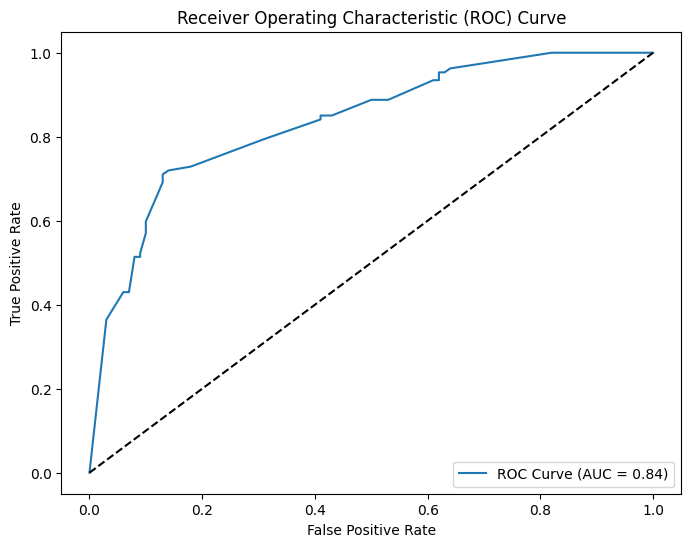

In [341]:
# Copy the final_df to a working dataframe
analysis_df = final_df.copy()

# Check and filter by settlementnaturesender
if 'settlementnaturesender' not in analysis_df.columns:
    raise ValueError("settlementnaturesender column not found.")

analysis_df = analysis_df.dropna(subset=['settlementnaturesender'])
analysis_df = analysis_df[analysis_df['imposition'] != 'Missing']

# Identify polity -1 year variables
polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]

# Listed TIES features (original + newly added)
ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'anticipatedtargetcosts',
    'anticipatedsendercosts',
    # Newly added features:
    'institution',  # treated as categorical
    'targetinstitution', # treated as categorical
    'othersanctiontypethreatened', # categorical
    'dsanctions' # categorical
]

all_features = polity_minus_one_vars + ties_features

# Check which features exist
final_features = []
for f in all_features:
    if f not in analysis_df.columns:
        print(f"Feature '{f}' not found, skipping it.")
    else:
        final_features.append(f)

if not final_features:
    raise ValueError("No features available after checking existence. Please revise variable selection.")

# Attempt to convert identified vars to numeric if possible
vars_to_process = final_features + ['settlementnaturesender']
for var in vars_to_process:
    analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

analysis_df = analysis_df[final_features + ['imposition']]

# Treat ties_features as categorical
for var in ties_features:
    if var in analysis_df.columns:
        # Convert all entries to string to ensure consistency
        analysis_df[var] = analysis_df[var].astype(str)
        analysis_df[var] = analysis_df[var].astype('category')
        # Add a "Missing" category to handle NaN explicitly
        analysis_df[var] = analysis_df[var].cat.add_categories(["Missing"])
        analysis_df[var] = analysis_df[var].fillna("Missing")

# For polity_minus_one_vars, median-impute missing values
for var in polity_minus_one_vars:
    if var in analysis_df.columns:
        col_median = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(col_median)

# Custom parsing function for any remaining non-numeric columns not in ties_features
def parse_numeric_string(val):
    if pd.isna(val):
        return val
    s = str(val)
    # Try to convert directly
    try:
        return float(s)
    except ValueError:
        # If it fails, maybe it's a space-separated pair of numbers
        parts = s.split()
        if len(parts) == 2:
            try:
                num1, num2 = float(parts[0]), float(parts[1])
                return (num1 + num2)/2.0
            except ValueError:
                return np.nan
        # If no known pattern, return NaN
        return np.nan

non_numeric_cols = analysis_df.select_dtypes(include=['object']).columns
for col in non_numeric_cols:
    if col not in ties_features:
        analysis_df[col] = analysis_df[col].apply(parse_numeric_string)
        # Try converting to numeric again
        analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')

# Remove columns that are entirely NaN
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        print(f"Feature '{var}' is all NaN, removing it.")
        final_features.remove(var)

if not final_features:
    raise ValueError("No usable features remain after removing all-NaN columns.")

# Define numerical and categorical features
numerical_features = [f for f in final_features if f in polity_minus_one_vars]
categorical_features = [f for f in ties_features if f in final_features]

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            # ('pca', PCA(n_components=0.90))  # Retain 90% of variance
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Define the pipeline with a Random Forest classifier
pipeline_prob_impose = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=10))  # Tune parameters as needed
])

# Prepare target and features
X = analysis_df[numerical_features + categorical_features]
y = analysis_df['imposition']

# Ensure 'imposition' is binary
unique_impositions = y.unique()
if not set(unique_impositions).issubset({0, 1}):
    raise ValueError(f"Target variable 'imposition' must be binary (0 and 1). Found: {unique_impositions}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Fit the pipeline on training data
pipeline_prob_impose.fit(X_train, y_train)

# Evaluate the model
train_score = pipeline_prob_impose.score(X_train, y_train)
test_score = pipeline_prob_impose.score(X_test, y_test)

print("Number of observations:", len(analysis_df))
onehot_feature_names = pipeline_prob_impose.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
print("Number of features after encoding:", len(numerical_features) + onehot_feature_names.shape[0])
print("Training Accuracy:", train_score)
print("Test Accuracy:", test_score)

# Predict probabilities on the test set
y_pred_proba = pipeline_prob_impose.predict_proba(X_test)[:, 1]

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC on test set:", roc_auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [12] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Confusion Matrix:
 [[82 18]
 [29 78]]
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.82      0.78       100
           1       0.81      0.73      0.77       107

    accuracy                           0.77       207
   macro avg       0.78      0.77      0.77       207
weighted avg       0.78      0.77      0.77       207

Feature importances (sorted):
Polity database: Regime Durability Index_-1: 0.0885
threatid1_nan: 0.0499
threatenedtargetinterest_nan: 0.0435
scommit_nan: 0.0405
anticipatedtargetcosts_nan: 0.0402
bspecif_nan: 0.0334
scommit_2.0: 0.0325
threatenedtargetinterest_3.0: 0.0284
sanctiontypethreat_nan: 0.0280
anticipatedtargetcosts_2.0: 0.0251
scommit_3.0: 0.0239
bspecif_2.0: 0.0222
Polity database: Combined Polity Score_-1: 0.0221
Polity database: Political Competition Concept_-1: 0.0214
Polity database: The Competitiveness of Participation_-1: 0.0209
Polity database: Regulation of Participation_-1: 0.0205
Pol

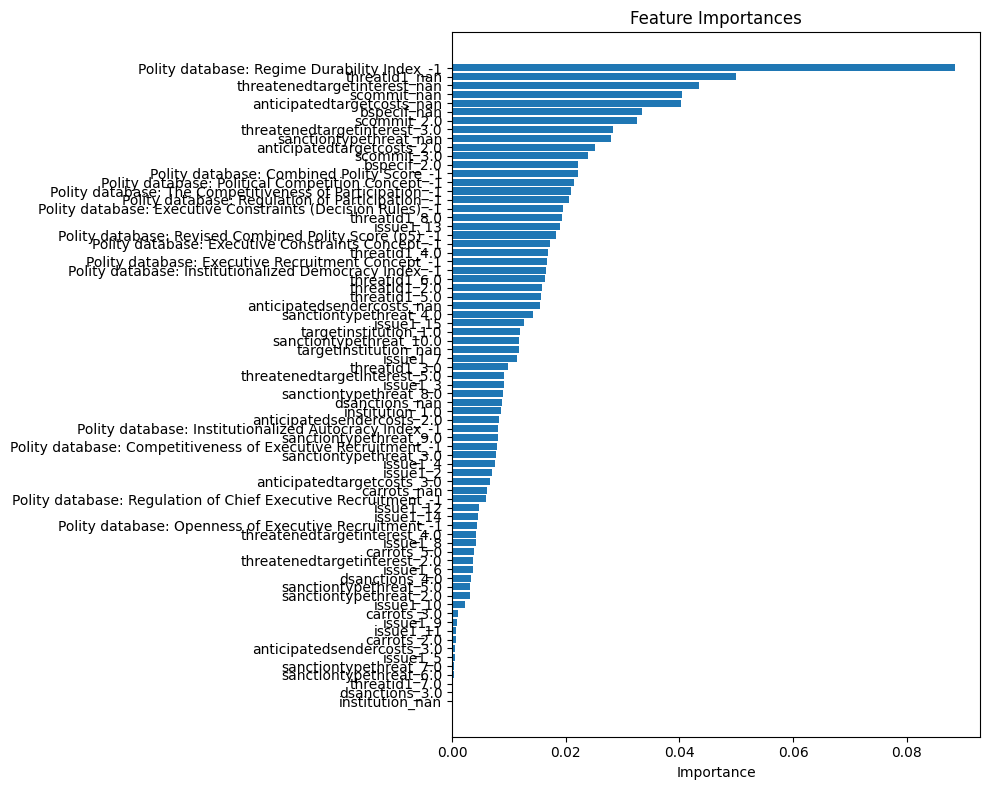

In [342]:
# Evaluate predictions
y_pred = pipeline_prob_impose.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Get the random forest estimator
rf = pipeline_prob_impose.named_steps['classifier']

# Extract the preprocessor step
preprocessor = pipeline_prob_impose.named_steps['preprocessor']

# Numeric and categorical features from your code
# Make sure numerical_features and categorical_features are defined beforehand
# numerical_features = [...]
# categorical_features = [...]

# After fitting the pipeline, get the OHE from the preprocessor
# The second element of each tuple in transformers_ is (transformer, columns)
# We know cat transformer is the second in our definition
ohe = preprocessor.transformers_[1][1]  # OneHotEncoder instance

# Get OHE feature names
cat_feature_names = ohe.get_feature_names_out(categorical_features)

# Combine numeric and categorical feature names for final list
final_feature_names = numerical_features + list(cat_feature_names)

# Check shapes
importances = rf.feature_importances_
if len(importances) != len(final_feature_names):
    raise ValueError("Mismatch in number of features and feature names.")

# Sort features by importance
indices = np.argsort(importances)[::-1]

print("Feature importances (sorted):")
for i in indices:
    print(f"{final_feature_names[i]}: {importances[i]:.4f}")

# Optional: Plot feature importances
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [final_feature_names[i] for i in indices])
plt.gca().invert_yaxis()  # Highest importance at top
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

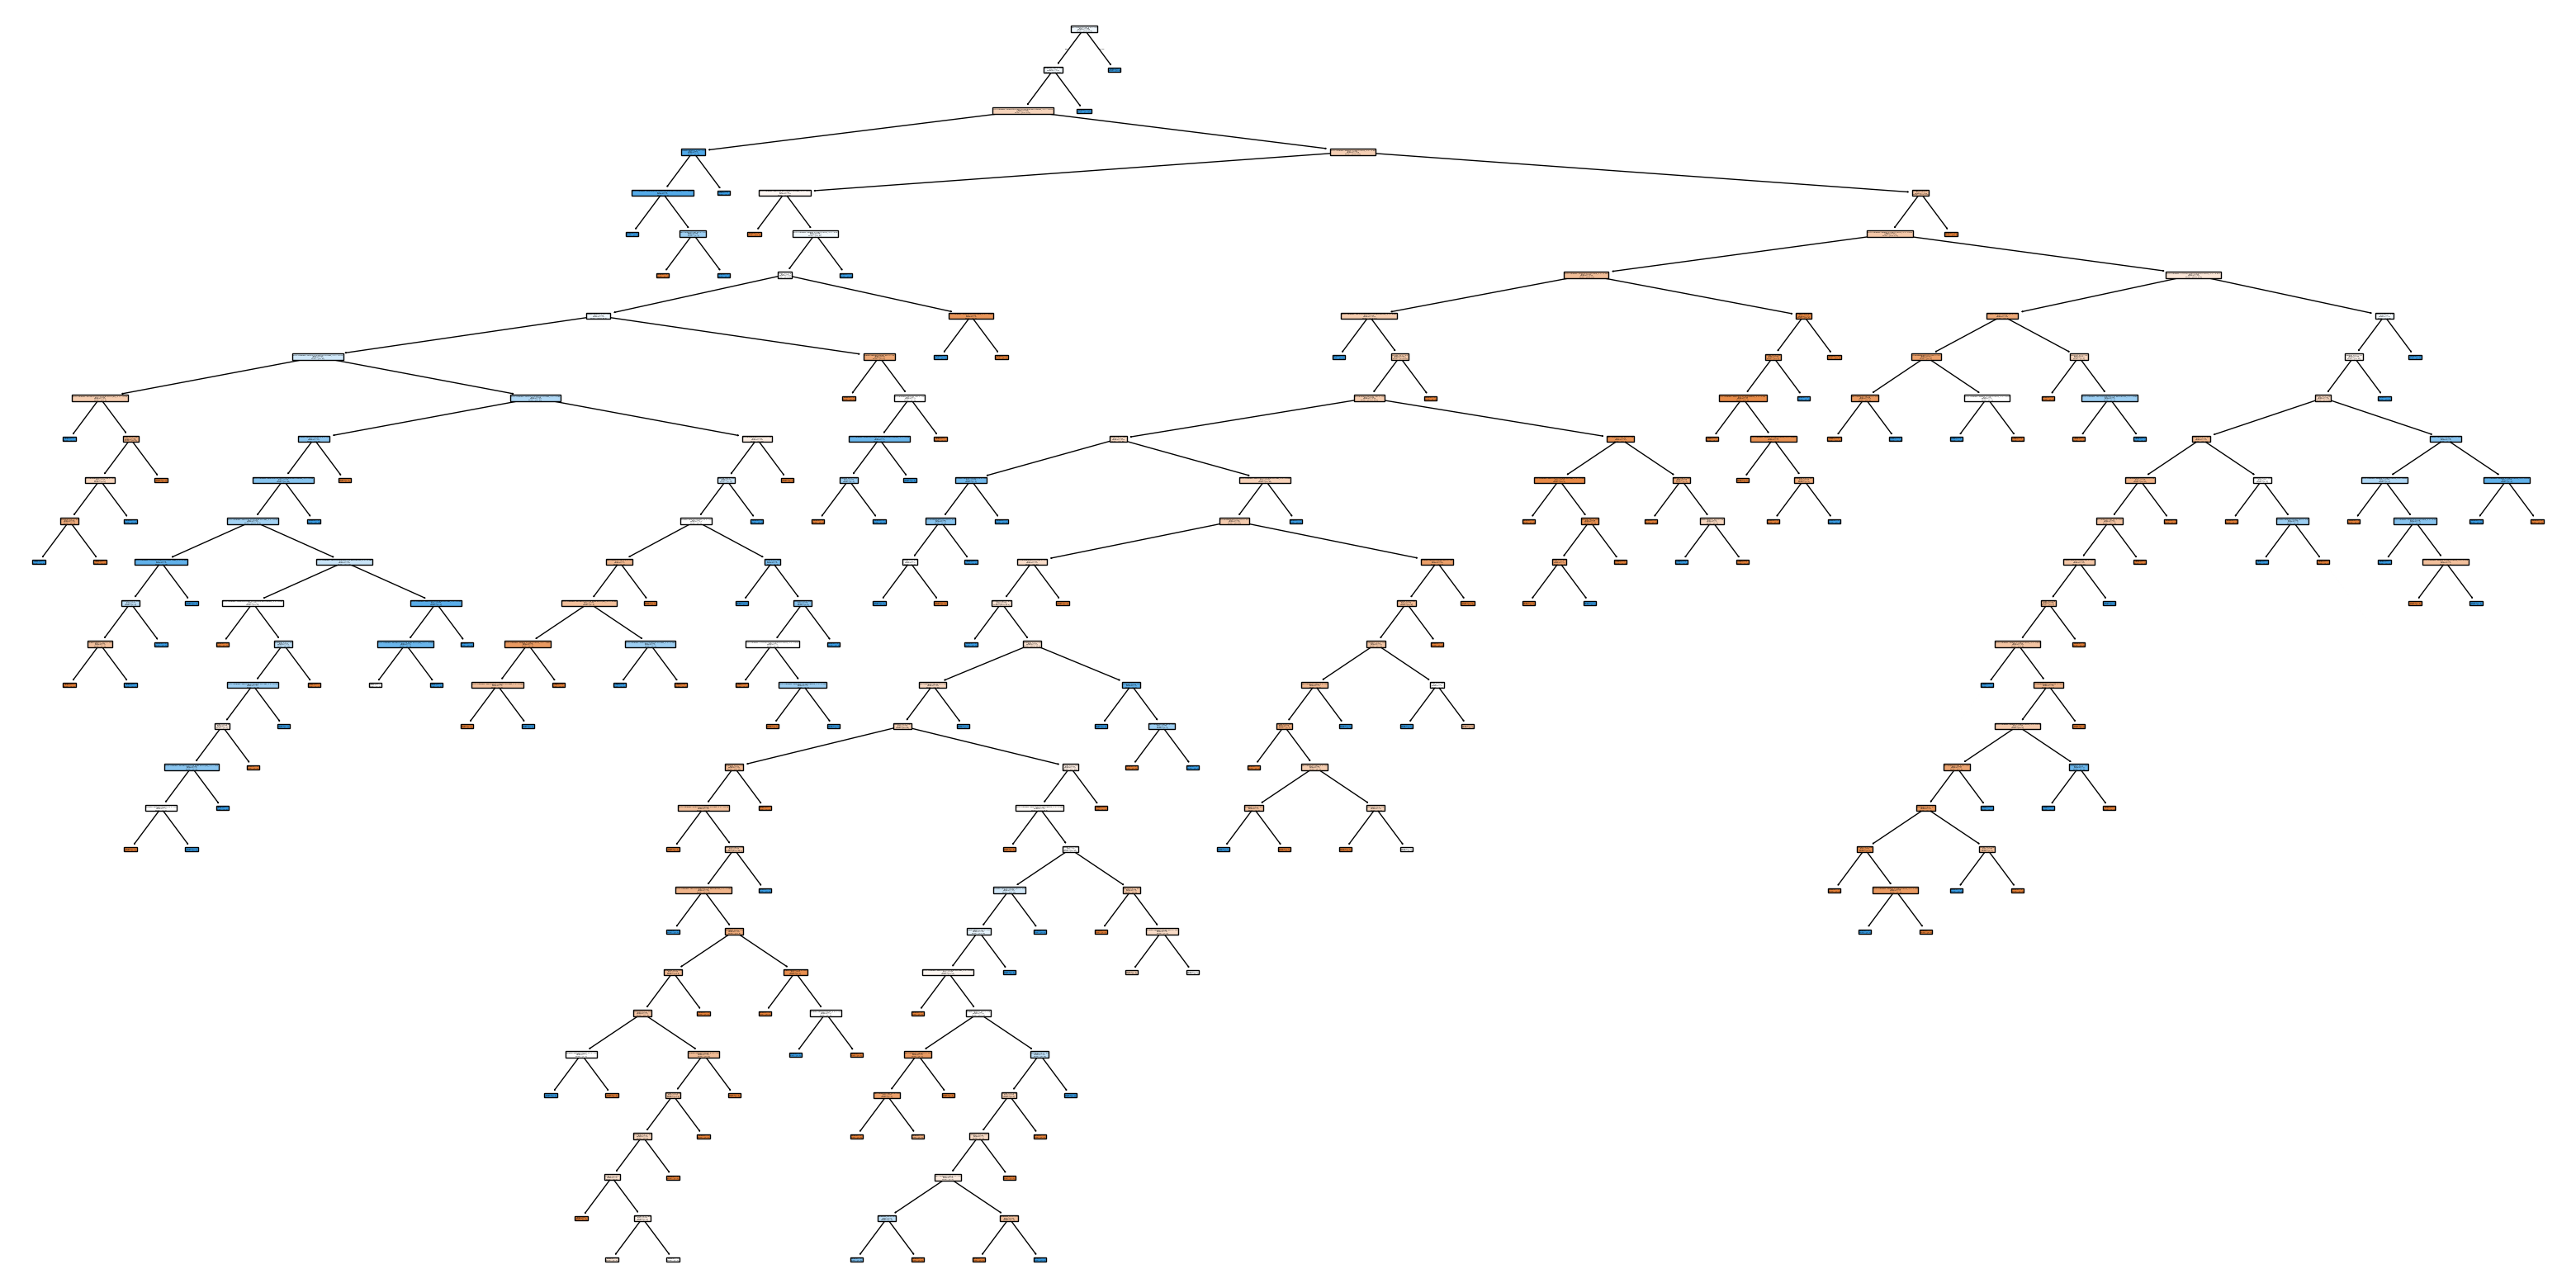

In [343]:
rf_classifier = pipeline_prob_impose.named_steps['classifier']
estimator = rf_classifier.estimators_[0]  # Access the first tree
# Extract numeric and categorical feature lists from the pipeline steps
numeric_features = pipeline_prob_impose.named_steps['preprocessor'].transformers_[0][2]
onehot_encoder = pipeline_prob_impose.named_steps['preprocessor'].transformers_[1][1]
categorical_features = pipeline_prob_impose.named_steps['preprocessor'].transformers_[1][2]

# Get final feature names after one-hot encoding
onehot_feature_names = onehot_encoder.get_feature_names_out(categorical_features)
feature_names = list(numeric_features) + list(onehot_feature_names)
plt.figure(figsize=(40, 20))  # Increase size even more
plot_tree(estimator, feature_names=feature_names, filled=True)
plt.show()

### Predicting Sucess from Threat

In [344]:
# Copy the final_df to a working dataframe
analysis_df = final_df.copy()

# Check and filter by settlementnaturesender
if 'settlementnaturesender' not in analysis_df.columns:
    raise ValueError("settlementnaturesender column not found.")

analysis_df = analysis_df.dropna(subset=['settlementnaturesender'])

analysis_df = analysis_df[analysis_df['settlementnaturesender'] >= 0]
analysis_df = analysis_df[analysis_df['threat'] == 1]

# Identify polity -1 year variables
polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]

# Listed TIES features
ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'anticipatedtargetcosts',
    'anticipatedsendercosts', 'institution', 'targetinstitution', 'othersanctiontypethreatened', 'dsanctions'
]

all_features = polity_minus_one_vars + ties_features

# Check which features exist
final_features = []
for f in all_features:
    if f not in analysis_df.columns:
        print(f"Feature '{f}' not found, skipping it.")
    else:
        final_features.append(f)

if not final_features:
    raise ValueError("No features available after checking existence. Please revise variable selection.")

# Attempt to convert identified vars to numeric if possible
vars_to_process = final_features + ['settlementnaturesender']
for var in vars_to_process:
    analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

analysis_df = analysis_df[final_features + ['settlementnaturesender']]

# Now treat ties_features as categorical
# (If they have multiple categories, we will one-hot encode them)
for var in ties_features:
    if var in analysis_df.columns:
        # Convert all entries to string to ensure consistency
        analysis_df[var] = analysis_df[var].astype(str)
        analysis_df[var] = analysis_df[var].astype('category')
        # Add a "Missing" category to handle NaN explicitly
        analysis_df[var] = analysis_df[var].cat.add_categories(["Missing"])
        analysis_df[var] = analysis_df[var].fillna("Missing")

# For polity_minus_one_vars, median-impute missing values
for var in polity_minus_one_vars:
    if var in analysis_df.columns:
        # Already numeric from above step
        col_median = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(col_median)

# If there are any remaining non-numeric features outside TIES or polity lists,
# handle them now. Some might have strings like "3760 4400".
# We'll attempt a custom parsing function.
def parse_numeric_string(val):
    if pd.isna(val):
        return val
    s = str(val)
    # Try to convert directly
    try:
        return float(s)
    except ValueError:
        # If it fails, maybe it's a space-separated pair of numbers
        parts = s.split()
        if len(parts) == 2:
            try:
                num1, num2 = float(parts[0]), float(parts[1])
                return (num1 + num2)/2.0
            except ValueError:
                return np.nan
        # If no known pattern, return NaN
        return np.nan

# Apply the parsing to any non-numeric columns that might remain
non_numeric_cols = analysis_df.select_dtypes(include=['object']).columns
for col in non_numeric_cols:
    # We only attempt to parse if this column isn't already processed as categorical
    if col not in ties_features: 
        analysis_df[col] = analysis_df[col].apply(parse_numeric_string)
        # Try converting to numeric again
        analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')

# Remove columns that are entirely NaN
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        print(f"Feature '{var}' is all NaN, removing it.")
        final_features.remove(var)

if not final_features:
    raise ValueError("No usable features remain after removing all-NaN columns.")


# Define numerical and categorical features
numerical_features = [f for f in final_features if f in polity_minus_one_vars]
categorical_features = [f for f in ties_features if f in final_features]

X_for_probs = analysis_df[numerical_features + categorical_features]
impose_probabilities = pipeline_prob_impose.predict_proba(X_for_probs)[:, 1]
analysis_df['pred_impose_prob'] = impose_probabilities


# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=0.90))  # Retain 95% of variance
        ]), numerical_features + ['pred_impose_prob']),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Define the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))  # Adjust alpha as needed
])

# Prepare target and features
X = analysis_df[numerical_features + categorical_features + ['pred_impose_prob']]
y = analysis_df['settlementnaturesender']


# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

# Evaluate the model
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print("---- Second Model (Settlement Nature Sender) ----")
print("Number of observations:", len(analysis_df))
print("Number of features after encoding:", len(numerical_features + ['pred_impose_prob']) +
      pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features).shape[0])
print("Intercept:", pipeline.named_steps['regressor'].intercept_)
print("R-squared on training set:", train_score)
print("R-squared on test set:", test_score)

# Retrieve feature names after preprocessing
num_features_scaled = numerical_features + ['pred_impose_prob']
cat_features_encoded = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = list(num_features_scaled) + list(cat_features_encoded)

# Retrieve coefficients
model_coefficients = pipeline.named_steps['regressor'].coef_

# Display coefficients
print("Feature coefficients in second model:")
for feature, coef in zip(all_feature_names, model_coefficients):
    print(f"{feature}: {coef}")

---- Second Model (Settlement Nature Sender) ----
Number of observations: 648
Number of features after encoding: 74
Intercept: 3.7143592238972967
R-squared on training set: 0.3600117311306559
R-squared on test set: 0.12583135180325067
Feature coefficients in second model:
Polity database: Combined Polity Score_-1: 0.015170286432630872
Polity database: Competitiveness of Executive Recruitment_-1: -0.3161197169241585
Polity database: Executive Constraints (Decision Rules)_-1: -0.08765052980740504
Polity database: Executive Constraints Concept_-1: 0.3508953292306367
Polity database: Executive Recruitment Concept_-1: -0.8532659491726712
Polity database: Institutionalized Autocracy Index_-1: 1.855094350558821
Polity database: Institutionalized Democracy Index_-1: 0.3337902603899377
Polity database: Openness of Executive Recruitment_-1: 2.934366659616108
Polity database: Political Competition Concept_-1: 0.4681544573252124
Polity database: Regime Durability Index_-1: -0.9439130148110048
Poli

In [345]:
print("Number of observations:", len(analysis_df))

# Calculate number of features after encoding
# Retrieve the PCA object to get the number of components
pca = pipeline.named_steps['preprocessor'].named_transformers_['num'].named_steps['pca']
num_pca_components = pca.n_components_

# Retrieve the number of categorical encoded features
onehot = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_encoded_features = onehot.get_feature_names_out(categorical_features)
num_cat_encoded = len(cat_encoded_features)

total_features = num_pca_components + num_cat_encoded
print("Number of features after PCA and encoding:", total_features)

print("Ridge Regression Model Details:")
print(f"Intercept: {pipeline.named_steps['regressor'].intercept_}")
print(f"R-squared on training set: {train_score:.4f}")
print(f"R-squared on test set: {test_score:.4f}")

# Retrieve feature names after preprocessing
# Note: PCA components are unnamed, so we'll name them as 'pca_0', 'pca_1', etc.
pca_feature_names = [f'pca_{i}' for i in range(num_pca_components)]
cat_features_encoded = list(cat_encoded_features)
all_feature_names = pca_feature_names + cat_features_encoded

# Retrieve coefficients
model_coefficients = pipeline.named_steps['regressor'].coef_


Number of observations: 648
Number of features after PCA and encoding: 62
Ridge Regression Model Details:
Intercept: 3.7143592238972967
R-squared on training set: 0.3600
R-squared on test set: 0.1258


In [346]:
# Copy the final_df to a working dataframe
analysis_df = final_df.copy()

# Check and filter by settlementnaturesender
if 'settlementnaturesender' not in analysis_df.columns:
    raise ValueError("settlementnaturesender column not found.")

analysis_df = analysis_df.dropna(subset=['settlementnaturesender'])

analysis_df = analysis_df[analysis_df['settlementnaturesender'] >= 0]
analysis_df = analysis_df[analysis_df['threat'] == 1]

# Identify polity -1 year variables
polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]

# Listed TIES features
ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'anticipatedtargetcosts',
    'anticipatedsendercosts', 'institution', 'targetinstitution', 'othersanctiontypethreatened', 'dsanctions'
]

all_features = polity_minus_one_vars + ties_features

# Check which features exist
final_features = []
for f in all_features:
    if f not in analysis_df.columns:
        print(f"Feature '{f}' not found, skipping it.")
    else:
        final_features.append(f)

if not final_features:
    raise ValueError("No features available after checking existence. Please revise variable selection.")

# Attempt to convert identified vars to numeric if possible
vars_to_process = final_features + ['settlementnaturesender']
for var in vars_to_process:
    analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

analysis_df = analysis_df[final_features + ['settlementnaturesender']]

# Now treat ties_features as categorical
# (If they have multiple categories, we will one-hot encode them)
for var in ties_features:
    if var in analysis_df.columns:
        # Convert all entries to string to ensure consistency
        analysis_df[var] = analysis_df[var].astype(str)
        analysis_df[var] = analysis_df[var].astype('category')
        # Add a "Missing" category to handle NaN explicitly
        analysis_df[var] = analysis_df[var].cat.add_categories(["Missing"])
        analysis_df[var] = analysis_df[var].fillna("Missing")

# For polity_minus_one_vars, median-impute missing values
for var in polity_minus_one_vars:
    if var in analysis_df.columns:
        # Already numeric from above step
        col_median = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(col_median)

# If there are any remaining non-numeric features outside TIES or polity lists,
# handle them now. Some might have strings like "3760 4400".
# We'll attempt a custom parsing function.
def parse_numeric_string(val):
    if pd.isna(val):
        return val
    s = str(val)
    # Try to convert directly
    try:
        return float(s)
    except ValueError:
        # If it fails, maybe it's a space-separated pair of numbers
        parts = s.split()
        if len(parts) == 2:
            try:
                num1, num2 = float(parts[0]), float(parts[1])
                return (num1 + num2)/2.0
            except ValueError:
                return np.nan
        # If no known pattern, return NaN
        return np.nan

# Apply the parsing to any non-numeric columns that might remain
non_numeric_cols = analysis_df.select_dtypes(include=['object']).columns
for col in non_numeric_cols:
    # We only attempt to parse if this column isn't already processed as categorical
    if col not in ties_features: 
        analysis_df[col] = analysis_df[col].apply(parse_numeric_string)
        # Try converting to numeric again
        analysis_df[col] = pd.to_numeric(analysis_df[col], errors='coerce')

# Remove columns that are entirely NaN
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        print(f"Feature '{var}' is all NaN, removing it.")
        final_features.remove(var)

if not final_features:
    raise ValueError("No usable features remain after removing all-NaN columns.")


# Define numerical and categorical features
numerical_features = [f for f in final_features if f in polity_minus_one_vars]
categorical_features = [f for f in ties_features if f in final_features]

X_for_probs = analysis_df[numerical_features + categorical_features]
impose_probabilities = pipeline_prob_impose.predict_proba(X_for_probs)[:, 1]
analysis_df['pred_impose_prob'] = impose_probabilities

# Predict imposition probabilities using the first model's pipeline
# We must ensure the second model's features match those used by the first model.
X_for_prob = analysis_df[numerical_features + categorical_features]
pred_impose_prob = pipeline_prob_impose.predict_proba(X_for_prob)[:, 1]

# Add the predicted probability as a new feature
analysis_df['pred_impose_prob'] = pred_impose_prob

# Include 'pred_impose_prob' in numerical_features for the second model
extended_numerical_features = numerical_features + ['pred_impose_prob']

# Now build the pipeline for the Random Forest Regressor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # This will pass through numerical features as is, including 'pred_impose_prob'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='median')),  # Impute any remaining missing values
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Prepare target and features
X = analysis_df[extended_numerical_features + categorical_features]
y = analysis_df['settlementnaturesender']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

# Evaluate the model
train_score = r2_score(y_train, y_train_pred)
test_score = r2_score(y_test, y_test_pred)

print("Number of observations:", len(analysis_df))

# Calculate number of features after encoding
onehot = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_encoded_features = onehot.get_feature_names_out(categorical_features)
num_cat_encoded = len(cat_encoded_features)
num_numerical = len(extended_numerical_features)
total_features = num_cat_encoded + num_numerical

print("Number of features after encoding:", total_features)

print("\nRandom Forest Regressor Model Details:")
print(f"Number of trees (n_estimators): {pipeline.named_steps['regressor'].n_estimators}")
print(f"R-squared on training set: {train_score:.4f}")
print(f"R-squared on test set: {test_score:.4f}")

# Feature Importance
# Retrieve feature names after preprocessing
all_feature_names = list(cat_encoded_features) + extended_numerical_features

importances = pipeline.named_steps['regressor'].feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importances.head(10).to_string(index=False))

Number of observations: 648
Number of features after encoding: 74

Random Forest Regressor Model Details:
Number of trees (n_estimators): 100
R-squared on training set: 0.8537
R-squared on test set: 0.2863

Top 10 Feature Importances:
                                               Feature  Importance
                                      pred_impose_prob    0.115348
           Polity database: Regime Durability Index_-1    0.088061
                                           bspecif_2.0    0.040765
                                 targetinstitution_nan    0.038553
                            anticipatedtargetcosts_2.0    0.038290
             Polity database: Combined Polity Score_-1    0.030871
                                             issue1_14    0.026894
Polity database: Revised Combined Polity Score (p5)_-1    0.025718
                          threatenedtargetinterest_5.0    0.024581
                                              issue1_7    0.024222


In [347]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [348]:
# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Full Pipeline with Feature Selection and Regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(score_func=f_regression, k=30)),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Define Parameter Grid (without PCA)
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'feature_selection__k': [20, 30, 40]
}


X_for_probs = analysis_df[numerical_features + categorical_features]
impose_probabilities = pipeline_prob_impose.predict_proba(X_for_probs)[:, 1]
analysis_df['pred_impose_prob'] = impose_probabilities

# Add the predicted probability as a new feature
analysis_df['pred_impose_prob'] = pred_impose_prob

# Include 'pred_impose_prob' in numerical_features for the second model
extended_numerical_features = numerical_features + ['pred_impose_prob']

# Prepare Target and Features
X = analysis_df[extended_numerical_features + categorical_features]
y = analysis_df['settlementnaturesender']

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Initialize GridSearchCV
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best Parameters
print("Best parameters found: ", grid_search.best_params_)

# Best Cross-Validation Score
print("Best cross-validation R-squared: ", grid_search.best_score_)

# Update Pipeline with Best Parameters
best_pipeline = grid_search.best_estimator_

# Predict on Test Set
y_test_pred = best_pipeline.predict(X_test)

# Evaluate on Test Set
test_score = r2_score(y_test, y_test_pred)
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print(f"R-squared on test set: {test_score:.4f}")
print(f"Mean Absolute Error on test set: {mae:.4f}")
print(f"Mean Squared Error on test set: {mse:.4f}")
print(f"Root Mean Squared Error on test set: {rmse:.4f}")

# Feature Importances
importances = best_pipeline.named_steps['regressor'].feature_importances_

# Get OneHotEncoder feature names
onehot = best_pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_encoded_features = onehot.get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(cat_encoded_features)

# Adjust if feature_selection reduced features
selected_mask = best_pipeline.named_steps['feature_selection'].get_support()
selected_features = [feature for feature, selected in zip(all_feature_names, selected_mask) if selected]

importances_selected = importances[:len(selected_features)]

# Create DataFrame for Feature Importances
feature_importances = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances_selected
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances:")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters found:  {'feature_selection__k': 40, 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 200}
Best cross-validation R-squared:  0.22935174040512735
R-squared on test set: 0.2154
Mean Absolute Error on test set: 2.2793
Mean Squared Error on test set: 7.5581
Root Mean Squared Error on test set: 2.7492

Top 10 Feature Importances:


In [393]:
# Copy the final_df to a working dataframe
analysis_df = final_df.copy()

analysis_df = analysis_df.dropna(subset=['finaloutcome'])
# Ensure 'finaloutcome' exists
if 'finaloutcome' not in analysis_df.columns:
    raise ValueError("finaloutcome column not found in final_df.")

# Ensure 'threat' and 'settlementnaturesender' exist (used in filtering)
if 'threat' not in analysis_df.columns:
    raise ValueError("threat column not found in final_df.")
if 'settlementnaturesender' not in analysis_df.columns:
    raise ValueError("settlementnaturesender column not found in final_df.")

# Filtering steps similar to the second snippet
analysis_df = analysis_df.dropna(subset=['settlementnaturesender'])
analysis_df = analysis_df[analysis_df['settlementnaturesender'] >= 0]
analysis_df = analysis_df[analysis_df['threat'] == 1]

# Identify polity -1 year variables
polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]

# Listed TIES features (same as in the second snippet)
ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'anticipatedtargetcosts',
    'anticipatedsendercosts', 'institution', 'targetinstitution', 
    'othersanctiontypethreatened', 'dsanctions'
]

all_features = polity_minus_one_vars + ties_features

# Check which features exist
final_features = []
for f in all_features:
    if f not in analysis_df.columns:
        print(f"Feature '{f}' not found, skipping it.")
    else:
        final_features.append(f)

if not final_features:
    raise ValueError("No features available after checking existence. Please revise variable selection.")

# Convert features to numeric where applicable
vars_to_process = final_features + ['settlementnaturesender']
for var in vars_to_process:
    analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

# Convert finaloutcome to categorical
analysis_df['finaloutcome'] = analysis_df['finaloutcome'].astype(str).astype('category')

# Treat categorical TIES features
for var in ties_features:
    if var in analysis_df.columns:
        analysis_df[var] = analysis_df[var].astype(str).astype('category')
        # Add a "Missing" category to handle NaN explicitly
        analysis_df[var] = analysis_df[var].cat.add_categories(["Missing"])
        analysis_df[var] = analysis_df[var].fillna("Missing")

# Median-impute for polity variables
for var in polity_minus_one_vars:
    if var in analysis_df.columns:
        col_median = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(col_median)

# Remove columns that are entirely NaN
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        print(f"Feature '{var}' is all NaN, removing it.")
        final_features.remove(var)

if not final_features:
    raise ValueError("No usable features remain after removing all-NaN columns.")

# Define numerical and categorical features
numerical_features = [f for f in final_features if f in polity_minus_one_vars]
categorical_features = [f for f in ties_features if f in final_features]

# ---------------------------------------------
# Incorporate predicted imposition probabilities
# ---------------------------------------------

# We assume pipeline_prob_impose is a previously trained model that predicts imposition probabilities.
# For that, we must use the same features that were used in pipeline_prob_impose's training.

# Prepare data for pipeline_prob_impose
X_for_probs = analysis_df[numerical_features + categorical_features]
impose_probabilities = pipeline_prob_impose.predict_proba(X_for_probs)[:, 1]
analysis_df['pred_impose_prob'] = impose_probabilities

# Add 'pred_impose_prob' as a numerical feature
extended_numerical_features = numerical_features + ['pred_impose_prob']

# Now we have final_features + pred_impose_prob to predict finaloutcome
X = analysis_df[extended_numerical_features + categorical_features]
y = analysis_df['finaloutcome']

# Build preprocessing pipeline for classification
# We'll scale only the numerical features and one-hot encode categorical features.
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # This keeps numerical features as is, including pred_impose_prob
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    min_samples_leaf=5, 
    random_state=42
))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Fit pipeline
pipeline.fit(X_train, y_train)

# Evaluate model
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("---- Final Outcome Classification Model ----")
print("Number of observations:", len(analysis_df))
print("Accuracy on training set:", train_accuracy)
print("Accuracy on test set:", test_accuracy)
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

# Retrieve feature names after preprocessing
onehot = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_encoded_features = onehot.get_feature_names_out(categorical_features)
all_feature_names = list(cat_encoded_features) + extended_numerical_features

importances = pipeline.named_steps['classifier'].feature_importances_

feature_importances = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importances.head(10).to_string(index=False))

---- Final Outcome Classification Model ----
Number of observations: 644
Accuracy on training set: 0.6438923395445134
Accuracy on test set: 0.4409937888198758
Classification Report on Test Set:
              precision    recall  f1-score   support

         1.0       0.50      0.17      0.25        12
        10.0       0.35      0.50      0.41        18
         2.0       0.57      0.64      0.60        33
         3.0       0.53      0.74      0.62        31
         4.0       0.00      0.00      0.00         4
         5.0       0.22      0.14      0.17        14
         6.0       0.00      0.00      0.00         9
         7.0       0.16      0.20      0.18        15
         8.0       0.50      0.58      0.54        19
         9.0       0.00      0.00      0.00         6

    accuracy                           0.44       161
   macro avg       0.28      0.30      0.28       161
weighted avg       0.39      0.44      0.40       161


Top 10 Feature Importances:
                  

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\maxla\

In [396]:
analysis_df = final_df.copy()

# Filter data
if 'settlementnaturesender' not in analysis_df.columns:
    raise ValueError("settlementnaturesender column not found.")
if 'finaloutcome' not in analysis_df.columns:
    raise ValueError("finaloutcome column not found.")
if 'threat' not in analysis_df.columns:
    raise ValueError("threat column not found.")

analysis_df = analysis_df.dropna(subset=['settlementnaturesender'])
analysis_df = analysis_df[analysis_df['settlementnaturesender'] >= 0]
analysis_df = analysis_df[analysis_df['threat'] == 1]

# Identify polity -1 year variables
polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]

# Listed TIES features
ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'anticipatedtargetcosts',
    'anticipatedsendercosts', 'institution', 'targetinstitution', 
    'othersanctiontypethreatened', 'dsanctions'
]

all_features = polity_minus_one_vars + ties_features

# Check feature existence
final_features = []
for f in all_features:
    if f in analysis_df.columns:
        final_features.append(f)
    else:
        print(f"Feature '{f}' not found, skipping it.")

if not final_features:
    raise ValueError("No features available after checking existence.")

# Convert to numeric where possible
vars_to_process = final_features + ['settlementnaturesender', 'finaloutcome']
for var in vars_to_process:
    if var in analysis_df.columns:
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

# Treat categorical TIES features
for var in ties_features:
    if var in analysis_df.columns:
        analysis_df[var] = analysis_df[var].astype(str).astype('category')
        # Add "Missing" category for NaNs
        analysis_df[var] = analysis_df[var].cat.add_categories(["Missing"])
        analysis_df[var] = analysis_df[var].fillna("Missing")

# Median-impute polity variables
for var in polity_minus_one_vars:
    if var in analysis_df.columns:
        col_median = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(col_median)

# Remove columns that are entirely NaN
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        print(f"Feature '{var}' is all NaN, removing it.")
        final_features.remove(var)

if not final_features:
    raise ValueError("No usable features remain after removing all-NaN columns.")

# Define numerical and categorical features
numerical_features = [f for f in final_features if f in polity_minus_one_vars]
categorical_features = [f for f in final_features if f in ties_features]

# Convert finaloutcome to binary:
# {1, 2, 5, 6, 7, 10} => 0, else => 1
zero_classes = {1.0, 2.0, 5.0, 6.0, 7.0, 10.0}
analysis_df['finaloutcome_binary'] = analysis_df['finaloutcome'].apply(lambda x: 0 if x in zero_classes else 1)

analysis_df = analysis_df.dropna(subset=['finaloutcome_binary'])

# ------------------------------------------------------------
# Include the predicted probability from pipeline_prob_impose
# ------------------------------------------------------------
X_for_probs = analysis_df[numerical_features + categorical_features]
analysis_df['pred_impose_prob'] = pipeline_prob_impose.predict_proba(X_for_probs)[:, 1]

# Add 'pred_impose_prob' to numerical features
extended_numerical_features = numerical_features + ['pred_impose_prob']

X = analysis_df[extended_numerical_features + categorical_features]
y = analysis_df['finaloutcome_binary']

# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), extended_numerical_features)
    ],
    remainder='drop'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Fit pipeline
pipeline.fit(X_train, y_train)

# Evaluate
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("---- Binary Classification Model with pred_impose_prob ----")
print("Number of observations:", len(analysis_df))
print("Accuracy on training set:", train_accuracy)
print("Accuracy on test set:", test_accuracy)
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

---- Binary Classification Model with pred_impose_prob ----
Number of observations: 648
Accuracy on training set: 0.9845559845559846
Accuracy on test set: 0.6384615384615384
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73        80
           1       0.54      0.40      0.46        50

    accuracy                           0.64       130
   macro avg       0.61      0.59      0.59       130
weighted avg       0.62      0.64      0.63       130



In [402]:
from sklearn.svm import SVC


analysis_df = final_df.copy()

# Filter data
if 'settlementnaturesender' not in analysis_df.columns:
    raise ValueError("settlementnaturesender column not found.")
if 'finaloutcome' not in analysis_df.columns:
    raise ValueError("finaloutcome column not found.")
if 'threat' not in analysis_df.columns:
    raise ValueError("threat column not found.")

analysis_df = analysis_df.dropna(subset=['settlementnaturesender'])
analysis_df = analysis_df[analysis_df['settlementnaturesender'] >= 0]
analysis_df = analysis_df[analysis_df['threat'] == 1]

# Identify polity -1 year variables
polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]

# Listed TIES features
ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'anticipatedtargetcosts',
    'anticipatedsendercosts', 'institution', 'targetinstitution', 
    'othersanctiontypethreatened', 'dsanctions'
]

all_features = polity_minus_one_vars + ties_features

# Check feature existence
final_features = []
for f in all_features:
    if f in analysis_df.columns:
        final_features.append(f)
    else:
        print(f"Feature '{f}' not found, skipping it.")

if not final_features:
    raise ValueError("No features available after checking existence.")

# Convert to numeric where possible
vars_to_process = final_features + ['settlementnaturesender', 'finaloutcome']
for var in vars_to_process:
    if var in analysis_df.columns:
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

# Treat categorical TIES features
for var in ties_features:
    if var in analysis_df.columns:
        analysis_df[var] = analysis_df[var].astype(str).astype('category')
        # Add "Missing" category for NaNs
        analysis_df[var] = analysis_df[var].cat.add_categories(["Missing"])
        analysis_df[var] = analysis_df[var].fillna("Missing")

# Median-impute polity variables
for var in polity_minus_one_vars:
    if var in analysis_df.columns:
        col_median = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(col_median)

# Remove columns that are entirely NaN
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        print(f"Feature '{var}' is all NaN, removing it.")
        final_features.remove(var)

if not final_features:
    raise ValueError("No usable features remain after removing all-NaN columns.")

# Define numerical and categorical features
numerical_features = [f for f in final_features if f in polity_minus_one_vars]
categorical_features = [f for f in final_features if f in ties_features]

# Convert finaloutcome to binary:
# {1, 2, 5, 6, 7, 10} => 0, else => 1
zero_classes = {1.0, 2.0, 5.0, 6.0, 7.0, 10.0}
analysis_df['finaloutcome_binary'] = analysis_df['finaloutcome'].apply(lambda x: 0 if x in zero_classes else 1)

analysis_df = analysis_df.dropna(subset=['finaloutcome_binary'])

# ------------------------------------------------------------
# Include the predicted probability from pipeline_prob_impose
# ------------------------------------------------------------
X_for_probs = analysis_df[numerical_features + categorical_features]
analysis_df['pred_impose_prob'] = pipeline_prob_impose.predict_proba(X_for_probs)[:, 1]

# Add 'pred_impose_prob' to numerical features
extended_numerical_features = numerical_features + ['pred_impose_prob']

X = analysis_df[extended_numerical_features + categorical_features]
y = analysis_df['finaloutcome_binary']

# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), extended_numerical_features)
    ],
    remainder='drop'
)

# Change the classifier to SVC
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('imputer', SimpleImputer(strategy='median')),
    ('classifier', SVC(probability=True, random_state=42, class_weight='balanced'))  # SVC default kernel='rbf', you can tune this
])

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Fit pipeline
pipeline.fit(X_train, y_train)

# Evaluate
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("---- Binary Classification Model with SVC ----")
print("Number of observations:", len(analysis_df))
print("Accuracy on training set:", train_accuracy)
print("Accuracy on test set:", test_accuracy)
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

---- Binary Classification Model with SVC ----
Number of observations: 648
Accuracy on training set: 0.7818532818532818
Accuracy on test set: 0.6384615384615384
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.73      0.65      0.69        80
           1       0.53      0.62      0.57        50

    accuracy                           0.64       130
   macro avg       0.63      0.64      0.63       130
weighted avg       0.65      0.64      0.64       130



### Analysis If Imposed

In [384]:
# Copy the final_df to a working dataframe
analysis_df = final_df.copy()

# Filter by settlementnaturesender
if 'settlementnaturesender' not in analysis_df.columns:
    raise ValueError("settlementnaturesender column not found.")

analysis_df = analysis_df.dropna(subset=['settlementnaturesender'])

# Filter for non-negative settlementnaturesender and threat=1
analysis_df = analysis_df[analysis_df['settlementnaturesender'] >= 0]

# New filter for imposed=1 (imposition=1)
if 'imposition' not in analysis_df.columns:
    raise ValueError("imposition column not found.")

analysis_df = analysis_df[analysis_df['imposition'] == 1]

# Identify polity -1 year variables
polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]

# Specified TIES features
ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'anticipatedtargetcosts',
    'anticipatedsendercosts', 'institution', 'targetinstitution', 'dsanctions',
    'sanctionidentity', 'sanctiontype', 'implementationofdiplomaticsancti',
    'carrotsduringsanction', 'targetcosts', 'sendercosts'
]

all_features = polity_minus_one_vars + ties_features

# Check feature existence
final_features = []
for f in all_features:
    if f not in analysis_df.columns:
        print(f"Feature '{f}' not found, skipping it.")
    else:
        final_features.append(f)

if not final_features:
    raise ValueError("No features available after checking existence. Please revise variable selection.")

# Determine numeric vs categorical features
# Polity vars are numeric
numeric_features_candidates = polity_minus_one_vars

# Among ties_features:
# Numeric: anticipatedtargetcosts, anticipatedsendercosts, targetcosts, sendercosts

# The rest of ties_features are categorical
categorical_features_candidates = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'institution', 'targetinstitution', 'dsanctions', 'sanctionidentity', 
    'sanctiontype', 'implementationofdiplomaticsancti',
    'carrotsduringsanction'
]

# Convert to numeric where applicable
vars_to_process = final_features + ['settlementnaturesender']
for var in vars_to_process:
    if var in numeric_features_candidates:
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')
    elif var not in categorical_features_candidates:
        # Attempt numeric conversion if it's not identified as categorical or numeric
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

analysis_df = analysis_df[final_features + ['settlementnaturesender']]

# Treat categorical features
for var in categorical_features_candidates:
    if var in analysis_df.columns:
        analysis_df[var] = analysis_df[var].astype(str).astype('category')
        # Add "Missing" category
        analysis_df[var] = analysis_df[var].cat.add_categories(["Missing"])
        analysis_df[var] = analysis_df[var].fillna("Missing")

# Impute median for numeric polity variables and numeric cost variables
for var in numeric_features_candidates:
    if var in analysis_df.columns:
        col_median = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(col_median)

# Remove columns that are entirely NaN (after attempts)
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        print(f"Feature '{var}' is all NaN, removing it.")
        final_features.remove(var)
        analysis_df = analysis_df.drop(columns=[var], errors='ignore')

if not final_features:
    raise ValueError("No usable features remain after removing all-NaN columns.")

# Redefine numerical and categorical features after cleaning
numerical_features = [f for f in final_features if f in numeric_features_candidates]
categorical_features = [f for f in final_features if f in categorical_features_candidates]

# Generate impose probabilities from pipeline_prob_impose (assumes already defined and fitted)
# For impose_prob, we use the original features that pipeline_prob_impose expects. 
# In this simplified example, let's assume pipeline_prob_impose was trained on the original ties_features and polity vars.

# Include pred_impose_prob as numeric
numerical_features = numerical_features 
# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            # ('pca', PCA(n_components=0.90))  # Retain 90% variance
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Define the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

X = analysis_df[numerical_features + categorical_features]
y = analysis_df['settlementnaturesender']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Fit pipeline
pipeline.fit(X_train, y_train)

# Evaluate model
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print("---- Second Model (Settlement Nature Sender) ----")
print("Number of observations:", len(analysis_df))
print("Number of features after encoding:",
      len(numerical_features) +
      pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features).shape[0])
print("Intercept:", pipeline.named_steps['regressor'].intercept_)
print("R-squared on training set:", train_score)
print("R-squared on test set:", test_score)

# Retrieve feature names after preprocessing
cat_features_encoded = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(cat_features_encoded)

# Retrieve coefficients
model_coefficients = pipeline.named_steps['regressor'].coef_

# Display coefficients
print("Feature coefficients in second model:")
for feature, coef in zip(all_feature_names, model_coefficients):
    print(f"{feature}: {coef}")

---- Second Model (Settlement Nature Sender) ----
Number of observations: 414
Number of features after encoding: 207
Intercept: 5.2624426318541975
R-squared on training set: 0.5104594098352662
R-squared on test set: 0.013037248635267562
Feature coefficients in second model:
Polity database: Combined Polity Score_-1: -0.1805486762716136
Polity database: Competitiveness of Executive Recruitment_-1: 0.2898195956719189
Polity database: Executive Constraints (Decision Rules)_-1: 0.22808685951548915
Polity database: Executive Constraints Concept_-1: 0.22808685951548915
Polity database: Executive Recruitment Concept_-1: 1.7286484716850055
Polity database: Institutionalized Autocracy Index_-1: -2.260320119505085
Polity database: Institutionalized Democracy Index_-1: -2.252866148191838
Polity database: Openness of Executive Recruitment_-1: 1.2217305732954398
Polity database: Political Competition Concept_-1: 0.3277935336058748
Polity database: Regime Durability Index_-1: 0.1986602032980275
Poli

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2, 5, 10, 11, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [383]:
# Copy the final_df to a working dataframe
analysis_df = final_df.copy()

# Filter by settlementnaturesender
if 'settlementnaturesender' not in analysis_df.columns:
    raise ValueError("settlementnaturesender column not found.")

analysis_df = analysis_df.dropna(subset=['settlementnaturesender'])

# Filter for non-negative settlementnaturesender and threat=1
analysis_df = analysis_df[analysis_df['settlementnaturesender'] >= 0]

# New filter for imposed=1 (imposition=1)
if 'imposition' not in analysis_df.columns:
    raise ValueError("imposition column not found.")

analysis_df = analysis_df[analysis_df['imposition'] == 1]

# Identify polity -1 year variables
polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]

# Specified TIES features
ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'institution', 'targetinstitution', 'dsanctions',
    'sanctionidentity', 'sanctiontype', 'implementationofdiplomaticsancti',
    'carrotsduringsanction',
]

all_features = polity_minus_one_vars + ties_features

# Check feature existence
final_features = []
for f in all_features:
    if f not in analysis_df.columns:
        print(f"Feature '{f}' not found, skipping it.")
    else:
        final_features.append(f)

if not final_features:
    raise ValueError("No features available after checking existence. Please revise variable selection.")

# Determine numeric vs categorical features
# Polity vars are numeric
numeric_features_candidates = polity_minus_one_vars

# Among ties_features:
# Numeric: anticipatedtargetcosts, anticipatedsendercosts, targetcosts, sendercosts

# The rest of ties_features are categorical
categorical_features_candidates = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'institution', 'targetinstitution', 'dsanctions', 'sanctionidentity', 
    'sanctiontype', 'implementationofdiplomaticsancti',
    'carrotsduringsanction'
]

# Convert to numeric where applicable
vars_to_process = final_features + ['settlementnaturesender']
for var in vars_to_process:
    if var in numeric_features_candidates:
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')
    elif var not in categorical_features_candidates:
        # Attempt numeric conversion if it's not identified as categorical or numeric
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

analysis_df = analysis_df[final_features + ['settlementnaturesender']]

# Treat categorical features
for var in categorical_features_candidates:
    if var in analysis_df.columns:
        analysis_df[var] = analysis_df[var].astype(str).astype('category')
        # Add "Missing" category
        analysis_df[var] = analysis_df[var].cat.add_categories(["Missing"])
        analysis_df[var] = analysis_df[var].fillna("Missing")

# Impute median for numeric polity variables and numeric cost variables
for var in numeric_features_candidates:
    if var in analysis_df.columns:
        col_median = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(col_median)

# Remove columns that are entirely NaN (after attempts)
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        print(f"Feature '{var}' is all NaN, removing it.")
        final_features.remove(var)
        analysis_df = analysis_df.drop(columns=[var], errors='ignore')

if not final_features:
    raise ValueError("No usable features remain after removing all-NaN columns.")

# Redefine numerical and categorical features after cleaning
numerical_features = [f for f in final_features if f in numeric_features_candidates]
categorical_features = [f for f in final_features if f in categorical_features_candidates]

# Build preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            # ('pca', PCA(n_components=0.90))  # Retain 90% variance
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Define the full pipeline with RandomForestRegressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

X = analysis_df[numerical_features + categorical_features]
y = analysis_df['settlementnaturesender']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Fit pipeline
pipeline.fit(X_train, y_train)

# Evaluate model
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print("---- Second Model (Settlement Nature Sender) using RandomForestRegressor ----")
print("Number of observations:", len(analysis_df))
# Count features after encoding
cat_features_encoded = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
# num_features_transformed = pipeline.named_steps['preprocessor'].transformers_[0][1]['pca'].n_components_
# total_features_after_encoding = num_features_transformed + len(cat_features_encoded)
# print("Number of features after encoding:", total_features_after_encoding)
print("R-squared on training set:", train_score)
print("R-squared on test set:", test_score)

# Retrieve feature names after preprocessing
all_feature_names = list(numerical_features) + list(cat_features_encoded)

# Retrieve feature importances (for the transformed features)
importances = pipeline.named_steps['regressor'].feature_importances_

print("Feature importances in second model:")
for feature, importance in zip(all_feature_names, importances):
    print(f"{feature}: {importance}")

---- Second Model (Settlement Nature Sender) using RandomForestRegressor ----
Number of observations: 414
R-squared on training set: 0.8336255393716727
R-squared on test set: -0.0645106054792044
Feature importances in second model:
Polity database: Combined Polity Score_-1: 0.04411648840809507
Polity database: Competitiveness of Executive Recruitment_-1: 0.006459903189799733
Polity database: Executive Constraints (Decision Rules)_-1: 0.008403286822613067
Polity database: Executive Constraints Concept_-1: 0.012243326197204744
Polity database: Executive Recruitment Concept_-1: 0.007666936872234693
Polity database: Institutionalized Autocracy Index_-1: 0.011368726974620444
Polity database: Institutionalized Democracy Index_-1: 0.019951674153342445
Polity database: Openness of Executive Recruitment_-1: 0.0024341547683010265
Polity database: Political Competition Concept_-1: 0.028514369145121995
Polity database: Regime Durability Index_-1: 0.1086587830229087
Polity database: Regulation of C

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2, 5, 10, 11, 13] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [381]:
from sklearn.metrics import accuracy_score, classification_report


# Copy the final_df to a working dataframe
analysis_df = final_df.copy()

# Filter by settlementnaturesender
if 'settlementnaturesender' not in analysis_df.columns:
    raise ValueError("settlementnaturesender column not found.")

analysis_df = analysis_df.dropna(subset=['settlementnaturesender'])

# Filter for non-negative settlementnaturesender and threat=1
analysis_df = analysis_df[analysis_df['settlementnaturesender'] >= 0]

# New filter for imposed=1 (imposition=1)
if 'imposition' not in analysis_df.columns:
    raise ValueError("imposition column not found.")

analysis_df = analysis_df[analysis_df['imposition'] == 1]

# Identify polity -1 year variables
polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]

# Specified TIES features
ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'institution', 'targetinstitution', 'dsanctions',
    'sanctionidentity', 'sanctiontype', 'implementationofdiplomaticsancti',
    'carrotsduringsanction',
]

all_features = polity_minus_one_vars + ties_features

# Check feature existence
final_features = []
for f in all_features:
    if f not in analysis_df.columns:
        print(f"Feature '{f}' not found, skipping it.")
    else:
        final_features.append(f)

if not final_features:
    raise ValueError("No features available after checking existence. Please revise variable selection.")

# Determine numeric vs categorical features
# Polity vars are numeric
numeric_features_candidates = polity_minus_one_vars

# Among ties_features, identify numeric ones if any:
# Assuming these cost variables may be in dataset (adjust as needed)
# numeric_cost_vars = ['anticipatedtargetcosts', 'anticipatedsendercosts', 'targetcosts', 'sendercosts']
# If they exist, we can add them to numeric_features_candidates accordingly.
# For now, let's assume no additional numeric cost vars were mentioned in original code snippet.

categorical_features_candidates = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'institution', 'targetinstitution', 'dsanctions', 
    'sanctionidentity', 'sanctiontype', 'implementationofdiplomaticsancti', 'carrotsduringsanction'
]

# Convert to numeric where applicable
vars_to_process = final_features + ['settlementnaturesender']
for var in vars_to_process:
    if var in numeric_features_candidates:
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')
    elif var not in categorical_features_candidates:
        # Attempt numeric conversion if it's not identified as categorical or numeric
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

analysis_df = analysis_df[final_features + ['settlementnaturesender', 'finaloutcome']]

# Ensure finaloutcome exists
if 'finaloutcome' not in analysis_df.columns:
    raise ValueError("finaloutcome column not found.")

# Convert finaloutcome to categorical
analysis_df['finaloutcome'] = analysis_df['finaloutcome'].astype(str).astype('category')

# Treat categorical features
for var in categorical_features_candidates:
    if var in analysis_df.columns:
        analysis_df[var] = analysis_df[var].astype(str).astype('category')
        # Add "Missing" category
        analysis_df[var] = analysis_df[var].cat.add_categories(["Missing"])
        analysis_df[var] = analysis_df[var].fillna("Missing")

# Impute median for numeric polity variables
for var in numeric_features_candidates:
    if var in analysis_df.columns:
        col_median = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(col_median)

# Remove columns that are entirely NaN (after attempts)
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        print(f"Feature '{var}' is all NaN, removing it.")
        final_features.remove(var)
        analysis_df = analysis_df.drop(columns=[var], errors='ignore')

if not final_features:
    raise ValueError("No usable features remain after removing all-NaN columns.")

# Redefine numerical and categorical features after cleaning
numerical_features = [f for f in final_features if f in numeric_features_candidates]
categorical_features = [f for f in final_features if f in categorical_features_candidates]

# Build preprocessing pipeline for classification
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
        ]), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# Define the full pipeline with RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

X = analysis_df[numerical_features + categorical_features]
y = analysis_df['finaloutcome']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# Fit pipeline
pipeline.fit(X_train, y_train)

# Evaluate model
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print("---- Final Outcome Classification Model using RandomForestClassifier ----")
print("Number of observations:", len(analysis_df))
print("Accuracy on training set:", train_accuracy)
print("Accuracy on test set:", test_accuracy)
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred_test))

# Retrieve feature names after preprocessing
cat_features_encoded = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(cat_features_encoded)

# Retrieve feature importances
importances = pipeline.named_steps['classifier'].feature_importances_

print("Feature importances in the classification model:")
for feature, importance in zip(all_feature_names, importances):
    print(f"{feature}: {importance}")

---- Final Outcome Classification Model using RandomForestClassifier ----
Number of observations: 414
Accuracy on training set: 0.9939577039274925
Accuracy on test set: 0.43373493975903615
Classification Report on Test Set:
              precision    recall  f1-score   support

        10.0       0.48      0.52      0.50        21
         6.0       0.12      0.09      0.11        11
         7.0       0.33      0.19      0.24        16
         8.0       0.53      0.70      0.60        27
         9.0       1.00      0.29      0.44         7
         nan       0.00      0.00      0.00         1

    accuracy                           0.43        83
   macro avg       0.41      0.30      0.32        83
weighted avg       0.46      0.43      0.42        83

Feature importances in the classification model:
Polity database: Combined Polity Score_-1: 0.022094881566686403
Polity database: Competitiveness of Executive Recruitment_-1: 0.012141825731795064
Polity database: Executive Constraint

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [2, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Autocracy Change Prediction

In [403]:
for c in final_df.columns:
    print(c)

caseid
startmonth
startday
startyear
endmonth
endday
endyear
ongoingasofmonth
ongoingasofday
ongoingasofyear
sender1
sender2
sender3
sender4
sender5
primarysender
targetstate
institution
institutionid
targetinstitution
otherinstitution
issue1
issue2
issue3
otherissue
threat
threatid1
threatid2
threatid3
sanctiontypethreat
othersanctiontypethreatened
bspecif
scommit
threatenedtargetinterest
dsanctions
carrots
anticipatedtargetcosts
anticipatedtargetcostsfigureifav
tcurrency
tyearofestimate
anticipatedsendercosts
scurrency
syearofestimate
imposition
sancimpositionstartmonth
sancimpositionstartday
sancimpositionstartyear
sanctionidentity
sanctiontype
othersanctiontype
implementationofdiplomaticsancti
carrotsduringsanction
carrotvalue
carrotcurrency
carrotyear
targetcosts
targeteconomiccostsfigure
targeteconomiccostscurrency
targeteconomiccostsyear
sendercosts
sendereconomiccostsfigure
sendereconomiccostscurrency
sendereconomiccostsyear
finaloutcome
settlementnaturesender
settlementnaturet

In [406]:
analysis_df

,caseid,startmonth,startday,startyear,endmonth,endday,endyear,ongoingasofmonth,ongoingasofday,ongoingasofyear,...,Polity database: The Competitiveness of Participation_11,Polity database: The Competitiveness of Participation_12,Polity database: The Competitiveness of Participation_13,Polity database: The Competitiveness of Participation_14,Polity database: The Competitiveness of Participation_15,Polity database: The Competitiveness of Participation_16,Polity database: The Competitiveness of Participation_17,Polity database: The Competitiveness of Participation_18,Polity database: The Competitiveness of Participation_19,Polity database: The Competitiveness of Participation_20
142,1960021301,2.0,13.0,1960,3.0,16.0,1964.0,NaN,NaN,NaN,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
143,1960032701,3.0,27.0,1960,6.0,23.0,1994.0,NaN,NaN,NaN,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
144,1960039901,3.0,NaN,1960,NaN,NaN,NaN,11.0,NaN,1982.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
145,1960050301,5.0,3.0,1960,5.0,12.0,1960.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146,1960051801,5.0,18.0,1960,3.0,18.0,1962.0,NaN,NaN,NaN,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1407,2005060701,6.0,7.0,2005,NaN,NaN,NaN,8.0,12.0,2011.0,...,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1408,2005062801,6.0,28.0,2005,9.0,1.0,2005.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1409,2005071401,7.0,14.0,2005,8.0,2.0,2005.0,NaN,NaN,NaN,...,3.0,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1410,2005100601,10.0,6.0,2005,6.0,17.0,2010.0,NaN,NaN,NaN,...,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [415]:
analysis_df = final_df.copy()

# The target variable is directly given:
target_col = "Polity database: Combined Polity Score_10"
if target_col not in analysis_df.columns:
    raise ValueError(f"Target column '{target_col}' not found in the DataFrame.")
analysis_df = analysis_df.dropna(subset=[target_col])

# Identify polity -1 year variables
polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]

# Specified TIES features
ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'institution', 'targetinstitution', 'dsanctions',
    'sanctionidentity', 'sanctiontype', 'implementationofdiplomaticsancti',
    'carrotsduringsanction',
]

final_features = polity_minus_one_vars + ties_features

# Check feature existence
existing_features = [f for f in final_features if f in analysis_df.columns]
missing_features = [f for f in final_features if f not in analysis_df.columns]

if missing_features:
    print("Warning: The following features are missing and will be skipped:", missing_features)

# Update final_features to only those present
final_features = existing_features

if not final_features:
    raise ValueError("No features available after checking existence.")

# Determine numeric vs categorical features
numeric_features_candidates = polity_minus_one_vars
categorical_features_candidates = ties_features

# Convert numeric candidates to numeric
for var in numeric_features_candidates:
    if var in analysis_df.columns:
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')

# For categorical features, ensure they are all strings and handle missing values uniformly
for var in categorical_features_candidates:
    if var in analysis_df.columns:
        # Convert to string, replace NaN with 'Missing'
        analysis_df[var] = analysis_df[var].astype(str)
        analysis_df[var] = analysis_df[var].replace('nan', 'Missing')
        analysis_df[var] = analysis_df[var].fillna('Missing')
        analysis_df[var] = analysis_df[var].astype('category')

# Impute median for numeric features
for var in numeric_features_candidates:
    if var in analysis_df.columns:
        col_median = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(col_median)

# Drop columns that ended up entirely NaN after processing
for var in list(final_features):
    if var not in analysis_df.columns:
        continue
    if analysis_df[var].isna().all():
        print(f"Feature '{var}' is all NaN, removing it.")
        final_features.remove(var)
        analysis_df.drop(columns=[var], inplace=True)

if not final_features:
    raise ValueError("No usable features remain after cleaning.")

# Separate numeric and categorical features
numerical_features = [f for f in final_features if f in numeric_features_candidates and f in analysis_df.columns]
categorical_features = [f for f in final_features if f in categorical_features_candidates and f in analysis_df.columns]

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# RandomForestRegressor since we predict a numeric score
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

X = analysis_df[numerical_features + categorical_features]
y = analysis_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print("---- 10-Year Autocracy Score Prediction Model ----")
print("Number of observations:", len(analysis_df))
print("R^2 on training set:", train_score)
print("R^2 on test set:", test_score)

# Retrieve encoded feature names
cat_features_encoded = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_features_encoded)

importances = pipeline.named_steps['regressor'].feature_importances_

print("Feature importances:")
for feature, importance in zip(all_feature_names, importances):
    print(f"{feature}: {importance}")

---- 10-Year Autocracy Score Prediction Model ----
Number of observations: 844
R^2 on training set: 0.9568023373110388
R^2 on test set: 0.667859455367577
Feature importances:
Polity database: Combined Polity Score_-1: 0.030482996986375743
Polity database: Competitiveness of Executive Recruitment_-1: 0.0021698018913377274
Polity database: Executive Constraints (Decision Rules)_-1: 0.008865051365812282
Polity database: Executive Constraints Concept_-1: 0.007486350456865663
Polity database: Executive Recruitment Concept_-1: 0.01660066899185246
Polity database: Institutionalized Autocracy Index_-1: 0.02773557041478383
Polity database: Institutionalized Democracy Index_-1: 0.0312474527168899
Polity database: Openness of Executive Recruitment_-1: 0.0030026831892300174
Polity database: Political Competition Concept_-1: 0.3121203426159564
Polity database: Regime Durability Index_-1: 0.06393916558470195
Polity database: Regulation of Chief Executive Recruitment_-1: 0.003847186958532193
Polity d

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2, 5, 6, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [417]:
# Assuming 'analysis_df' is your final dataframe with the necessary columns.
# 'Polity database: Institutionalized Autocracy Index_10' is our target.
target_col = "Polity database: Combined Polity Score_10"

# Ensure no NaNs in the target
analysis_df = analysis_df.dropna(subset=[target_col])

# Identify numeric and categorical features
# numeric_features: all columns ending in '_-1' (polity_minus_one_vars)
# categorical_features: ties_features
polity_minus_one_vars = [col for col in analysis_df.columns if col.endswith('_-1')]

ties_features = [
    'issue1', 'threatid1', 'sanctiontypethreat', 'bspecif', 'scommit',
    'threatenedtargetinterest', 'carrots', 'institution', 'targetinstitution', 
    'dsanctions', 'sanctionidentity', 'sanctiontype', 
    'implementationofdiplomaticsancti', 'carrotsduringsanction'
]

numeric_features_candidates = polity_minus_one_vars
categorical_features_candidates = ties_features

# Convert numeric candidates to numeric
for var in numeric_features_candidates:
    if var in analysis_df.columns:
        analysis_df[var] = pd.to_numeric(analysis_df[var], errors='coerce')
        # Impute median if needed
        median_val = analysis_df[var].median()
        analysis_df[var] = analysis_df[var].fillna(median_val)

# For categorical features, ensure they are strings, replace NaN with 'Missing'
for var in categorical_features_candidates:
    if var in analysis_df.columns:
        analysis_df[var] = analysis_df[var].astype(str)
        analysis_df[var] = analysis_df[var].replace('nan', 'Missing')
        analysis_df[var] = analysis_df[var].fillna('Missing')
        analysis_df[var] = analysis_df[var].astype('category')

# Final feature sets
final_features = [f for f in numeric_features_candidates if f in analysis_df.columns] \
                 + [f for f in categorical_features_candidates if f in analysis_df.columns]

numerical_features = [f for f in final_features if f in numeric_features_candidates]
categorical_features = [f for f in final_features if f in categorical_features_candidates]

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ],
    remainder='drop'
)

# RandomForestRegressor pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

X = analysis_df[numerical_features + categorical_features]
y = analysis_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

pipeline.fit(X_train, y_train)

train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

print("---- RandomForestRegressor Model ----")
print("Number of observations:", len(analysis_df))
print("R² on training set:", train_score)
print("R² on test set:", test_score)

# Feature importances
cat_features_encoded = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(cat_features_encoded)
importances = pipeline.named_steps['regressor'].feature_importances_

print("Feature importances:")
for feature, importance in zip(all_feature_names, importances):
    print(f"{feature}: {importance}")

---- RandomForestRegressor Model ----
Number of observations: 844
R² on training set: 0.9568023373110388
R² on test set: 0.667859455367577
Feature importances:
Polity database: Combined Polity Score_-1: 0.030482996986375743
Polity database: Competitiveness of Executive Recruitment_-1: 0.0021698018913377274
Polity database: Executive Constraints (Decision Rules)_-1: 0.008865051365812282
Polity database: Executive Constraints Concept_-1: 0.007486350456865663
Polity database: Executive Recruitment Concept_-1: 0.01660066899185246
Polity database: Institutionalized Autocracy Index_-1: 0.02773557041478383
Polity database: Institutionalized Democracy Index_-1: 0.0312474527168899
Polity database: Openness of Executive Recruitment_-1: 0.0030026831892300174
Polity database: Political Competition Concept_-1: 0.3121203426159564
Polity database: Regime Durability Index_-1: 0.06393916558470195
Polity database: Regulation of Chief Executive Recruitment_-1: 0.003847186958532193
Polity database: Regula

c:\Users\maxla\OneDrive\Documents\GitHub\RCM\EconCoerFinal\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [1, 2, 5, 6, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Works over most time spans for that but not for autocracy